##Analysis starts from here

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import folium
import requests
import json
print('Libraries imported.')

Libraries imported.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install geocoder
import geocoder
print('successfully installed and imported')

successfully installed and imported


In [6]:
# Read Dataframe 
nyc_zips = pd.read_html('https://www.zipcodestogo.com/New%20York/')
nyc_zips = nyc_zips[1]
# Rename Columns
nyc_zips.rename(columns={0:'Zip Code',1:'City',2:'County',3:'Zip Code Map'},inplace=True)
# Drop Headers
nyc_zips.drop([0,1],axis=0,inplace=True)
# Reset Index
nyc_zips.reset_index(inplace=True)
# Drop Unnecessary Columns
nyc_zips.drop(['index','Zip Code Map'],axis=1,inplace=True)

# Filter the dataframe into smaller dataframes, then concatenate as new dataframe
Bronx_Zip = nyc_zips[nyc_zips['County']=='Bronx']
Brooklyn_Zip = nyc_zips[nyc_zips['County']=='Kings']
Manhattan_Zip = nyc_zips[nyc_zips['County']=='New York']
Queens_Zip = nyc_zips[nyc_zips['County']=='Queens']
Staten_Island_Zip = nyc_zips[nyc_zips['County']=='Richmond']
Extra_Zip = nyc_zips[nyc_zips['Zip Code']=='11040']
Extra_Zip2 = nyc_zips[nyc_zips['Zip Code']=='11001']
Original_Zip = pd.DataFrame({'Zip Code':['10065','10075'],'City':['New York','New York'],'County':['New York','New York']})

nyc_zips=pd.concat([Bronx_Zip,Brooklyn_Zip,Manhattan_Zip,Queens_Zip,Staten_Island_Zip,Extra_Zip,Extra_Zip2,Original_Zip], axis=0)

# Drop Unnecessary Columns(Not included in the zipcode of the other dataframe)
nyc_zips.drop(368, axis=0,inplace=True)

# Change datatype of the zipcode from string to integer & Sort it in ascending order
nyc_zips['Zip Code'] = nyc_zips['Zip Code'].astype(int)
nyc_zips.sort_values(by='Zip Code', inplace=True)

# Save Variable for future merging
Zip_Code_checker = nyc_zips['Zip Code']

In [7]:
ny_crimes = pd.read_csv('/content/drive/MyDrive/Data/index-crimes-by-county-and-agency-beginning-1990.csv')
ny_crimes.columns

#Limiting the range of dataset on New York City and time range of >2010
ny_crimes = ny_crimes[ny_crimes['Region']=='New York City']
ny_crimes = ny_crimes[ny_crimes['Year']>2010]

#Drop unwanted features and rows containing na values
ny_crimes.drop(['Agency','Months Reported','Region','Violent Total','Property Total'], axis=1, inplace=True)
ny_crimes.dropna(axis=0,how='any',inplace=True)

#Changing data type from float to integer
ny_crimes.loc[:,'Index Total':'Motor Vehicle Theft'] = ny_crimes.loc[:,'Index Total':'Motor Vehicle Theft'].astype(int)

#Change the County name to more familiar name
ny_crimes.County = ny_crimes.County.replace(['Kings','New York','Richmond'],['Brooklyn','Manhattan','Staten Island'])

print(ny_crimes.shape)
ny_crimes.head(15)

(40, 10)


County  Year  Index Total  Murder  Rape  Robbery  \
25            Bronx  2018        35355      91   662     3213   
211        Brooklyn  2018        50106      98   802     4157   
280       Manhattan  2018        49830      31   640     2731   
401          Queens  2018        33135      65   582     2534   
414   Staten Island  2018         5738      10   128      327   
655           Bronx  2017        35507      72   551     3570   
847        Brooklyn  2017        49766     111   709     4497   
916       Manhattan  2017        47146      46   530     2749   
1039         Queens  2017        32860      50   495     2851   
1052  Staten Island  2017         5969      13    90      328   
1296          Bronx  2016        36834      98   615     4297   
1489       Brooklyn  2016        50802     128   678     4907   
1562      Manhattan  2016        46653      41   494     2929   
1684         Queens  2016        33800      47   486     2989   
1697  Staten Island  2016         6313      21    99      422   

      Aggravated Assault  Burglary  Larceny  Motor Vehicle Theft  
25                  8548      2095    19434                 1312  
211                 9327      3585    30417                 1720  
280                 5549      2455    37682                  742  
401                 5675      2360    20344                 1575  
414                  943       342     3803                  185  
655                 8341      2108    19509                 1356  
847                 9276      3659    29589                 1925  
916                 5346      2215    35622                  638  
1039                5788      2721    19373                 1582  
1052                1020       401     3883                  234  
1296                8807      2459    19191                 1367  
1489                9810      3832    29366                 2081  
1562                5375      2206    34867                  741  
1684                5834      3056    19455                 1933  
1697                1047       488     3989                  247

In [8]:
ny_crimes_grouped = ny_crimes.groupby(['County'])
for key, group in ny_crimes_grouped:
  print('# key',key)
  print('# number',len(group))
  print(group.head(8))
  print('\n')

# key Bronx
# number 8
     County  Year  Index Total  Murder  Rape  Robbery  Aggravated Assault  \
25    Bronx  2018        35355      91   662     3213                8548   
655   Bronx  2017        35507      72   551     3570                8341   
1296  Bronx  2016        36834      98   615     4297                8807   
1945  Bronx  2015        36299      91   556     4386                8376   
2591  Bronx  2014        36030      95   242     4004                8372   
3247  Bronx  2013        36280      83   189     4456                8292   
3903  Bronx  2012        35962     114   220     4731                7736   
4563  Bronx  2011        35130     148   204     4580                7335   

      Burglary  Larceny  Motor Vehicle Theft  
25        2095    19434                 1312  
655       2108    19509                 1356  
1296      2459    19191                 1367  
1945      2530    18767                 1593  
2591      2739    19104                 1474  
3

In [9]:
'''Bronx_crime = ny_crimes_grouped.get_group('Bronx')
Bronx_crime = Bronx_crime[['Year','Index Total']]
Bronx_crime.sort_values(by='Year', inplace=True)
Bronx_crime.drop('Year',axis=1,inplace=True)
Bronx_crime.reset_index(inplace=True)
Bronx_crime.drop('index',axis=1,inplace=True)
Bronx_crime'''

"Bronx_crime = ny_crimes_grouped.get_group('Bronx')\nBronx_crime = Bronx_crime[['Year','Index Total']]\nBronx_crime.sort_values(by='Year', inplace=True)\nBronx_crime.drop('Year',axis=1,inplace=True)\nBronx_crime.reset_index(inplace=True)\nBronx_crime.drop('index',axis=1,inplace=True)\nBronx_crime"

In [10]:
def total_crime_year(name):
  crime=ny_crimes_grouped.get_group(name)
  crime = crime[['Year','Index Total']]
  crime.sort_values(by='Year', inplace=True)
  crime.set_index('Year', inplace=True)
  crime.rename(columns={'Index Total':f'{name} Total'},inplace=True)
  
  return(crime)

In [11]:
Bronx_crime=total_crime_year('Bronx')
Brooklyn_crime=total_crime_year('Brooklyn')
Manhattan_crime=total_crime_year('Manhattan')
Queens_crime=total_crime_year('Queens')
Staten_Island_crime=total_crime_year('Staten Island')

In [12]:
total_crime = pd.concat([Bronx_crime,Brooklyn_crime,Manhattan_crime,Queens_crime,Staten_Island_crime], axis=1)
total_crime.rename(columns={'Bronx Total':'Bronx','Brooklyn Total':'Brooklyn','Manhattan Total':'Manhattan','Queens Total':'Queens', 'Staten Island Total':'Staten Island'}, inplace=True)
total_crime

Bronx  Brooklyn  Manhattan  Queens  Staten Island
Year                                                   
2011  35130     59014      50858   39863           6801
2012  35962     60690      51756   40199           7146
2013  36280     59056      51872   39913           7234
2014  36030     56700      47566   38030           6865
2015  36299     53957      47307   35920           6465
2016  36834     50802      46653   33800           6313
2017  35507     49766      47146   32860           5969
2018  35355     50106      49830   33135           5738

In [13]:
# Read CSV Files
ny_crimes_violent = pd.read_csv('/content/drive/MyDrive/Data/index-crimes-by-county-and-agency-beginning-1990.csv')

# Select Necessary Features
ny_crimes_violent = ny_crimes_violent[ny_crimes_violent['Region']=='New York City']
ny_crimes_violent = ny_crimes_violent[ny_crimes_violent['Year']>2010]

ny_crimes_violent = ny_crimes_violent[['County','Year','Violent Total']]

# Drop NA Values
ny_crimes_violent.dropna(axis=0, how= 'any', inplace=True)

# Change Datetype from float to integer
ny_crimes_violent['Violent Total'] = ny_crimes_violent['Violent Total'].astype(int)

# Change Names of the Boroughs
ny_crimes_violent.County= ny_crimes_violent.County.replace(['Kings','New York','Richmond'], ['Brooklyn','Manhattan','Staten Island'])

# Group Dataframe by Boroughs
ny_crimes_violent_grouped = ny_crimes_violent.groupby('County')

In [14]:
def total_violent_year(name):
  violent = ny_crimes_violent_grouped.get_group(name)
  violent = violent[['Year', 'Violent Total']]
  violent.set_index('Year', inplace=True)
  violent.sort_index(inplace=True)
  violent.rename(columns={'Violent Total':f'{name} Violent'},inplace=True)
  return violent

In [15]:
Bronx_violent=total_violent_year('Bronx')
Brooklyn_violent=total_violent_year('Brooklyn')
Manhattan_violent=total_violent_year('Manhattan')
Queens_violent=total_violent_year('Queens')
Staten_Island_violent=total_violent_year('Staten Island')

In [16]:
total_violent = pd.concat([Bronx_violent,Brooklyn_violent,Manhattan_violent,Queens_violent,Staten_Island_violent], axis=1)
total_violent.rename(columns={'Bronx Violent':'Bronx','Brooklyn Violent':'Brooklyn','Manhattan Violent':'Manhattan','Queens Violent':'Queens', 'Staten Island Violent':'Staten Island'}, inplace=True)
total_violent

Bronx  Brooklyn  Manhattan  Queens  Staten Island
Year                                                   
2011  12267     18182       9021   10311           1428
2012  12801     18673       9102   10753           1664
2013  13020     18258       8708   10740           1658
2014  12713     17053       8327    9800           1551
2015  13409     16385       8789    9854           1651
2016  13817     15523       8839    9356           1589
2017  12534     14593       8671    9184           1451
2018  12514     14384       8951    8856           1408

In [17]:
# Create ratio of Total Violent Crime out of Total Crime Dataframe
total_violent_array = total_violent.to_numpy()
total_crime_array = total_crime.to_numpy()
total_violent_ratio = total_violent_array/total_crime_array
total_violent_ratio_df = pd.DataFrame(total_violent_ratio, index=[i for i in range(2011,2019)], columns=['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
total_violent_ratio_df

Bronx  Brooklyn  Manhattan    Queens  Staten Island
2011  0.349189  0.308096   0.177376  0.258661       0.209969
2012  0.355959  0.307678   0.175864  0.267494       0.232858
2013  0.358875  0.309164   0.167875  0.269085       0.229195
2014  0.352845  0.300758   0.175062  0.257691       0.225929
2015  0.369404  0.303668   0.185786  0.274332       0.255375
2016  0.375115  0.305559   0.189463  0.276805       0.251703
2017  0.353001  0.293232   0.183918  0.279489       0.243089
2018  0.353953  0.287071   0.179631  0.267270       0.245382

Text(0.5, 1.0, 'Total-Violent Ratio')

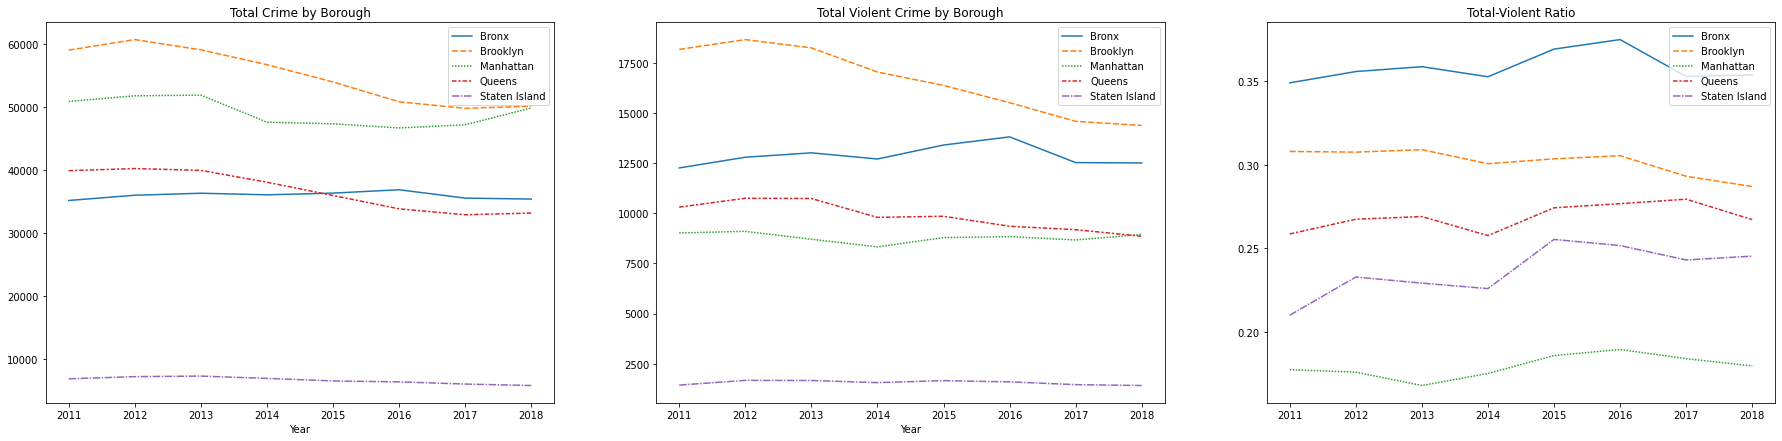

In [18]:
# Plot Data
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(31,7))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
#ax4 = plt.subplot(1,4,4)


sns.lineplot(data=total_crime, ax=ax1).set_title('Total Crime by Borough')
sns.lineplot(data=total_violent, ax= ax2).set_title('Total Violent Crime by Borough')
sns.lineplot(data=total_violent_ratio_df, ax=ax3).set_title('Total-Violent Ratio')
#sns.lineplot(data=ny_rodent_1118_initial_grouped, ax=ax4).set_title('Total Initial Rodent Inspection')


Interesting Findings:
1. When it comes to the total crime which has happened, the Brooklyn is the borough with the most of the crime. Moreover, Brooklyn has the highest frequency of occurence in both total crime and violence crime as well.
2. Bronx, which is in the midpoint(or behind of the midpoint) on the sorted order of the total crime, actually has high violent crime occurance. When considering the ratio of total # of crimes and total # of violent crimes, Bronx has the highest Total-Violent Ratio.
3. Manhattan on the other hand, is the second highest(or the highest based on the latest year) on # of total crimes, but when it comes to total violent crime, Manhattan is in the second last position, and when we see the Total-Violent Ratio, Manhattan has the lowest ratio, indicating that there's the least possibility that the crime happened is a violent crime.
4. Staten Island has the least values on the first two graph and I assume that's because of the difference in the size of population between Staten Island and others is huge(Population info from Wikipedia -> Bronx: 1,418,207, Brooklyn: 2,559,903, Manhattan: 1,628,706, Queens: 2,253,858, Staten Island: 476,143).

Future Approach:
1. As we have the rodent inspection data available in Kaggle, we will use this data to see if there's any correlation between frequency of rodent being observed and crime rate.
2. I believe high number of rodent being inspected means the sanity condition of the following city isn't good. My basic assumption comes from the broken window theory, which is a criminological theory that states that visible signs of crime, anti-social behavior, and civil disorder create an urban environment that encourages further crime and disorder, including serious crimes. Although observing a rodent isn't crime, but I want to see if we can stretch this theory into a larger scale.
3. As the dataset isn't big enough to conclude into certain result (only have the data from 2011~2018), hopefully this can show glimpse of the result and can lead to further investigation later.

In [19]:
# Read Dataframe 
nyc_zips = pd.read_html('https://www.zipcodestogo.com/New%20York/')
nyc_zips = nyc_zips[1]
# Rename Columns
nyc_zips.rename(columns={0:'Zip Code',1:'City',2:'County',3:'Zip Code Map'},inplace=True)
# Drop Headers
nyc_zips.drop([0,1],axis=0,inplace=True)
# Reset Index
nyc_zips.reset_index(inplace=True)
# Drop Unnecessary Columns
nyc_zips.drop(['index','Zip Code Map'],axis=1,inplace=True)

# Filter the dataframe into smaller dataframes, then concatenate as new dataframe
Bronx_Zip = nyc_zips[nyc_zips['County']=='Bronx']
Brooklyn_Zip = nyc_zips[nyc_zips['County']=='Kings']
Manhattan_Zip = nyc_zips[nyc_zips['County']=='New York']
Queens_Zip = nyc_zips[nyc_zips['County']=='Queens']
Staten_Island_Zip = nyc_zips[nyc_zips['County']=='Richmond']
Extra_Zip = nyc_zips[nyc_zips['Zip Code']=='11040']
Extra_Zip2 = nyc_zips[nyc_zips['Zip Code']=='11001']
Original_Zip = pd.DataFrame({'Zip Code':['10065','10075'],'City':['New York','New York'],'County':['New York','New York']})

nyc_zips=pd.concat([Bronx_Zip,Brooklyn_Zip,Manhattan_Zip,Queens_Zip,Staten_Island_Zip,Extra_Zip,Extra_Zip2,Original_Zip], axis=0)

# Drop Unnecessary Columns(Not included in the zipcode of the other dataframe)
nyc_zips.drop(368, axis=0,inplace=True)

# Change datatype of the zipcode from string to integer & Sort it in ascending order
nyc_zips['Zip Code'] = nyc_zips['Zip Code'].astype(int)
nyc_zips.sort_values(by='Zip Code', inplace=True)

# Save Variable for future merging
Zip_Code_checker = nyc_zips['Zip Code']

In [20]:
ny_rodent = pd.read_csv('/content/drive/MyDrive/Data/rodent-inspection.csv')

# Select useful features for future analysis
ny_rodent = ny_rodent[['INSPECTION_TYPE','INSPECTION_DATE','BORO_CODE','BOROUGH','LATITUDE','LONGITUDE','ZIP_CODE','RESULT']]

# Ruling out the rows with the value of nan values
nyr_initial = ny_rodent.shape
ny_rodent.ZIP_CODE = ny_rodent.ZIP_CODE.replace(0,np.nan)
ny_rodent.dropna(axis=0, how='any', inplace=True)
nyr_after = ny_rodent.shape
print(f'initial = {nyr_initial}, after: {nyr_after}')
print(f'# of dropped data: {nyr_initial[0]-nyr_after[0]}')

# change the datatype of ZIP_CODE from float to int
ny_rodent.ZIP_CODE = ny_rodent.ZIP_CODE.astype(int)

# change the data type of INSPECTION_DATE from object type to datetime data type
ny_rodent.INSPECTION_DATE = pd.to_datetime(ny_rodent.INSPECTION_DATE)
ny_rodent['YEAR'] = pd.DatetimeIndex(ny_rodent['INSPECTION_DATE']).year
ny_rodent.drop('INSPECTION_DATE',axis=1,inplace=True)

# As we are planning to compare the rodent inspection & crime in the city, filter the year in a range from 2011~2018
ny_rodent_1118 = ny_rodent[(ny_rodent.YEAR>=2011)&(ny_rodent.YEAR<=2018)]
ny_rodent_1118.sort_values(by='YEAR',inplace=True)

#
pd.set_option('display.max_rows', 100)
ny_rodent_1118_initial = ny_rodent_1118[ny_rodent_1118.INSPECTION_TYPE=='INITIAL']
#ny_rodent_1118_initial.groupby(['YEAR','BOROUGH']).count()
ny_rodent_1118_initial = ny_rodent_1118_initial[['BOROUGH','YEAR','INSPECTION_TYPE']]
ny_rodent_1118_initial_grouped = ny_rodent_1118_initial.groupby(['YEAR','BOROUGH']).count()
ny_rodent_1118_initial_grouped.rename(columns={'INSPECTION_TYPE':'COUNT'},inplace=True)
#ny_rodent_1118_initial_grouped.reset_index('BOROUGH',inplace=True)
ny_rodent_1118_initial_grouped=ny_rodent_1118_initial_grouped.unstack(level=-1)
ny_rodent_1118_initial_grouped.columns=ny_rodent_1118_initial_grouped.columns.droplevel()
ny_rodent_1118_initial_grouped

ny_rodent.head()

initial = (1812887, 8), after: (1796637, 8)
# of dropped data: 16250


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


INSPECTION_TYPE  BORO_CODE        BOROUGH   LATITUDE  LONGITUDE  ZIP_CODE  \
0         INITIAL          3       Brooklyn  40.706139 -73.935536     11206   
1         INITIAL          4         Queens  40.672262 -73.845715     11417   
2         INITIAL          5  Staten Island  40.558825 -74.122979     10306   
3         INITIAL          3       Brooklyn  40.603337 -74.005784     11214   
4         INITIAL          2          Bronx  40.807270 -73.922596     10454   

              RESULT  YEAR  
0   Active Rat Signs  2017  
1  Passed Inspection  2017  
2  Passed Inspection  2017  
3  Passed Inspection  2017  
4  Passed Inspection  2017

In [21]:
ny_rodent_1118_initial_grouped

BOROUGH  Bronx  Brooklyn  Manhattan  Queens  Staten Island
YEAR                                                      
2011     25922     20556      46707   14322           2667
2012     27762     41159      46285   10608           2158
2013     36895     17876      27552    9379           1909
2014     35558     18306      27315    9867           4411
2015     41920     14295      29121    9960           1418
2016     37574     18942      50770   12470           3097
2017     47096     43842      58714   16465           4670
2018     43833     63804      61616    6967           1949

Text(0.5, 1.0, 'Total-Violent Ratio')

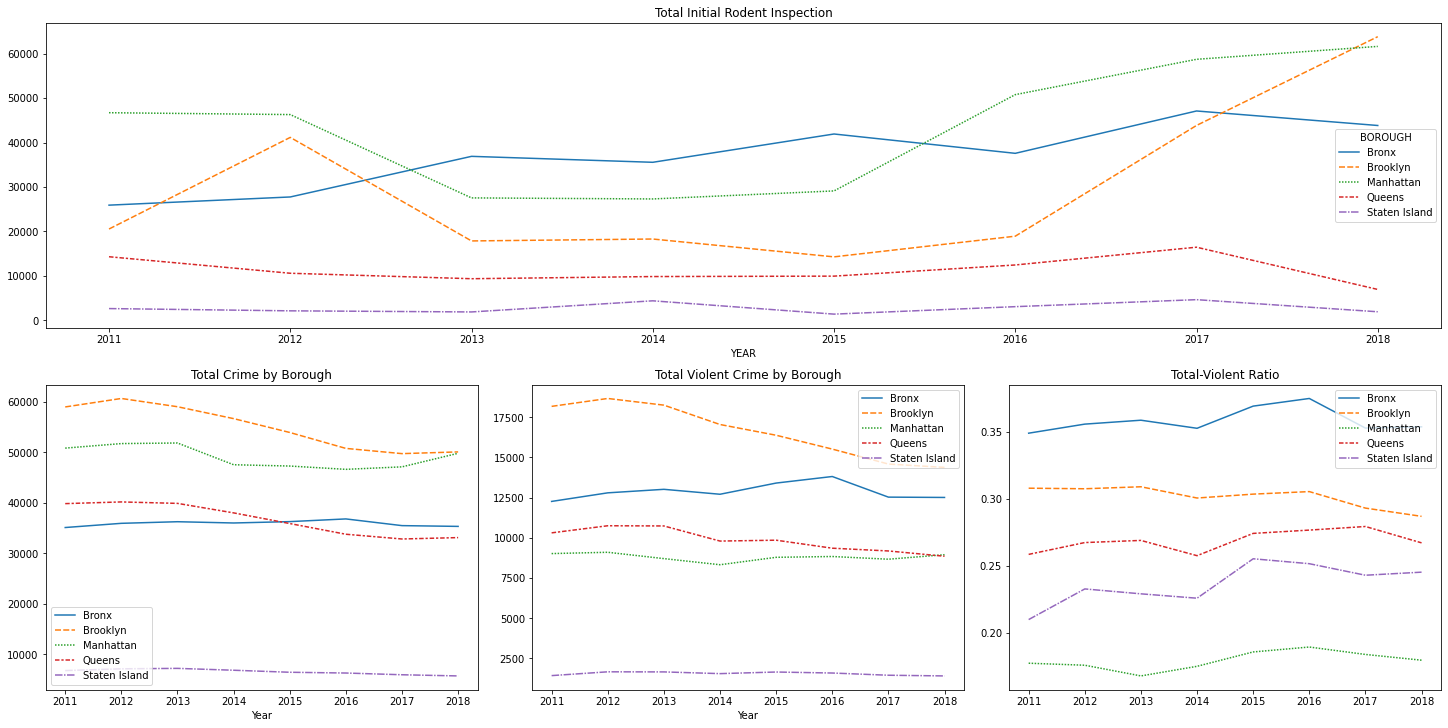

In [22]:
# Plot Data
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,10),constrained_layout=True)
gs = fig.add_gridspec(4, 3)
ax1 = fig.add_subplot(gs[:2, :])
sns.lineplot(data=ny_rodent_1118_initial_grouped, ax=ax1).set_title('Total Initial Rodent Inspection')

ax2 = fig.add_subplot(gs[2:,0])
sns.lineplot(data=total_crime, ax=ax2).set_title('Total Crime by Borough')

ax3 = fig.add_subplot(gs[2:,1])
sns.lineplot(data=total_violent, ax= ax3).set_title('Total Violent Crime by Borough')

ax4 = fig.add_subplot(gs[2:,2])
sns.lineplot(data=total_violent_ratio_df, ax=ax4).set_title('Total-Violent Ratio')

As we can see in the graph, it seems like some cities have correlation between sanity condition and crime rate, but I'm not sure if it is actually a significant factor influencing the crime rate in boroughs of NYC. Therefore, we should go through linear regression to look into the actual correlation.

In [23]:
# Test iteration for defining proccess

# Extract crime_df
test_df1=total_crime['Manhattan']
# Change index name so it is same with merging df
test_df1.index.name = f'{test_df1.index.name.upper()}'
# Extract rodent_df
test_df2=ny_rodent_1118_initial_grouped['Manhattan']

# Check if it's done well 
print(test_df1.index.name)
print('\n')
print(test_df1)
print('\n')
print(test_df2)

# Merge data
test_merge=pd.merge(test_df1,test_df2,how='inner', on='YEAR')
test_merge

YEAR


YEAR
2011    50858
2012    51756
2013    51872
2014    47566
2015    47307
2016    46653
2017    47146
2018    49830
Name: Manhattan, dtype: int64


YEAR
2011    46707
2012    46285
2013    27552
2014    27315
2015    29121
2016    50770
2017    58714
2018    61616
Name: Manhattan, dtype: int64


Manhattan_x  Manhattan_y
YEAR                          
2011        50858        46707
2012        51756        46285
2013        51872        27552
2014        47566        27315
2015        47307        29121
2016        46653        50770
2017        47146        58714
2018        49830        61616

In [24]:
Borough_dict = {}
#Extract Features
Borough_list = ['Manhattan','Bronx','Brooklyn','Queens','Staten Island']
# for loop
for i, a in zip(Borough_list,range(5)):
  #Extract Series
  temp_df1 = total_crime[i]
  temp_df1.index.name = f'{temp_df1.index.name.upper()}'
  temp_df2 = ny_rodent_1118_initial_grouped[i]
    #Merge
  Borough_dict[a]=pd.merge(temp_df1,temp_df2,how='inner',on='YEAR')

# Assigning Variable using For loop
Borough_list = ['Manhattan','Bronx','Brooklyn','Queens','Staten_Island']
for i, name in zip(range(5),Borough_list):
  globals()[f'{name}_Crime_Rodent'] = Borough_dict.get(i)


In [25]:
# Test if the variable is assigned correctly
Staten_Island_Crime_Rodent

Staten Island_x  Staten Island_y
YEAR                                  
2011             6801             2667
2012             7146             2158
2013             7234             1909
2014             6865             4411
2015             6465             1418
2016             6313             3097
2017             5969             4670
2018             5738             1949

In [26]:
Staten_Island_Crime_Rodent.columns[0]

'Staten Island_x'

In [27]:
Manhattan_Crime_Rodent.rename(columns={'Manhattan_x':'Manhattan_Total_Crime',
                                       'Manhattan_y':'Manhattan_Rodent'},inplace=True)
Bronx_Crime_Rodent.rename(columns={'Bronx_x':'Bronx_Total_Crime',
                                       'Bronx_y':'Bronx_Rodent'},inplace=True)
Brooklyn_Crime_Rodent.rename(columns={'Brooklyn_x':'Brooklyn_Total_Crime',
                                       'Brooklyn_y':'Brooklyn_Rodent'},inplace=True)
Queens_Crime_Rodent.rename(columns={'Queens_x':'Queens_Total_Crime',
                                       'Queens_y':'Queens_Rodent'},inplace=True)
Staten_Island_Crime_Rodent.rename(columns={'Staten Island_x':'Staten_Island_Total_Crime',
                                       'Staten Island_y':'Staten_Island_Rodent'},inplace=True)

In [28]:
Bronx_Crime_Rodent

Bronx_Total_Crime  Bronx_Rodent
YEAR                                 
2011              35130         25922
2012              35962         27762
2013              36280         36895
2014              36030         35558
2015              36299         41920
2016              36834         37574
2017              35507         47096
2018              35355         43833

In [29]:
#### NEED TO WORK ON ####
'''def merge_crime_rodent(df1,df2):
  Borough_dict = {}
  #Extract Features
  Borough_list = ['Manhattan','Bronx','Brooklyn','Queens','Staten Island']
  # For loop
  for i, a in zip(Borough_list,range(5)):
    #Extract Series
    temp_df1 = df1[i]
    temp_df1.index.name = f'{temp_df1.index.name.upper()}'
    temp_df2 = df2[i]
      #Merge
    Borough_dict[a]=pd.merge(temp_df1,temp_df2,how='inner',on='YEAR')
  return Borough_dict
  # Assigning Variable using For loop
def extract_each_dataframe(Borough_dict,content_name):
  Borough_list = ['Manhattan','Bronx','Brooklyn','Queens','Staten Island']
  for i, name in zip(range(5),Borough_list):
    globals()[f'{name}_{content_name}'] = Borough_dict.get(i)'''

#### Test Ver. ####

'''merge_crime_rodent(total_crime,ny_rodent_1118_initial_grouped)
Borough_dict
#extract_each_dataframe(Borough_dict,'Crime_Rodent_Test')
#Bronx_Crime_Rodent_Test'''

'''Manhattan_crirod = a[0]
Bronx_crirod = a[1]
Brooklyn_crirod = a[2]
Queens_crirod = a[3]
Staten_Island_crirod = a[4]'''

'Manhattan_crirod = a[0]\nBronx_crirod = a[1]\nBrooklyn_crirod = a[2]\nQueens_crirod = a[3]\nStaten_Island_crirod = a[4]'

In [30]:
from scipy.stats import pearsonr

Manhattan_corr=pearsonr(Manhattan_Crime_Rodent.Manhattan_Total_Crime,Manhattan_Crime_Rodent.Manhattan_Rodent)
Bronx_corr=pearsonr(Bronx_Crime_Rodent.Bronx_Total_Crime,Bronx_Crime_Rodent.Bronx_Rodent)
Brooklyn_corr=pearsonr(Brooklyn_Crime_Rodent.Brooklyn_Total_Crime,Brooklyn_Crime_Rodent.Brooklyn_Rodent)
Queens_corr=pearsonr(Queens_Crime_Rodent.Queens_Total_Crime,Queens_Crime_Rodent.Queens_Rodent)
Staten_Island_corr=pearsonr(Staten_Island_Crime_Rodent.Staten_Island_Total_Crime,Staten_Island_Crime_Rodent.Staten_Island_Rodent)

In [31]:
print(f'Correlation between Total Crime and # of Rodent in Manhattan: {Manhattan_corr}')
print(f'Correlation between Total Crime and # of Rodent in Bronx: {Bronx_corr}')
print(f'Correlation between Total Crime and # of Rodent in Brooklyn: {Brooklyn_corr}')
print(f'Correlation between Total Crime and # of Rodent in Queens: {Queens_corr}')
print(f'Correlation between Total Crime and # of Rodent in Staten Island: {Staten_Island_corr}')

Correlation between Total Crime and # of Rodent in Manhattan: (-0.06953758123536095, 0.8700367345277515)
Correlation between Total Crime and # of Rodent in Bronx: (0.08620202283489609, 0.8391701085412983)
Correlation between Total Crime and # of Rodent in Brooklyn: (-0.3967412089223015, 0.3304847388628119)
Correlation between Total Crime and # of Rodent in Queens: (-0.1139682285634931, 0.7881527432450698)
Correlation between Total Crime and # of Rodent in Staten Island: (-0.19086974081089103, 0.650716268447651)


Looking at the correlation between the Total Crime and number of Rodent(Sanity level of Borough), it is hard to say that there is a correlation because of few reasons:
1. The p value is higher than 0.05, which makes us hard to reject the null hypothesis that there is no correlation between # of crimes and # of rodent.
2. The correlation between # of crimes and # of rodent are very low.
3. The correlation should be fairly constant in order to make a reasonable conclusion, but correlation of each Borough is distinctive to each others (some have negative correlation while the others have positive correlation).

However, still it is a bit dangerous to make a conclusion as the sample size is only from (2011~2018). 8 samples cannot really tell the correlation well so we need to collect more sample in order to make a reasonable conclusion.

As we cannot do this at this point, let us look into correlation between Total Crime - Violent Crime ratio and # of rodents on each Borough. It will either reassure our updated expectation or might show a different outcome.

In [32]:
total_violent_ratio_df

Bronx  Brooklyn  Manhattan    Queens  Staten Island
2011  0.349189  0.308096   0.177376  0.258661       0.209969
2012  0.355959  0.307678   0.175864  0.267494       0.232858
2013  0.358875  0.309164   0.167875  0.269085       0.229195
2014  0.352845  0.300758   0.175062  0.257691       0.225929
2015  0.369404  0.303668   0.185786  0.274332       0.255375
2016  0.375115  0.305559   0.189463  0.276805       0.251703
2017  0.353001  0.293232   0.183918  0.279489       0.243089
2018  0.353953  0.287071   0.179631  0.267270       0.245382

In [33]:
# View the filtered df first
total_violent_ratio_df['Manhattan']

# Assign name for
total_violent_ratio_df.index.name = 'YEAR'

Borough_dict2 = {}

Borough_list = ['Manhattan','Bronx','Brooklyn','Queens','Staten Island']

for i, a in zip(Borough_list,range(5)):
  temp_df1 = total_violent_ratio_df[i]
  temp_df2 = ny_rodent_1118_initial_grouped[i]

  Borough_dict[a]=pd.merge(temp_df1,temp_df2, how='inner', on = 'YEAR')
  
Borough_list = ['Manhattan','Bronx','Brooklyn','Queens','Staten_Island']

for i, name in zip(range(5),Borough_list):
  globals()[f'{name}_TVCRatio_Rodent'] = Borough_dict.get(i)

In [34]:
Staten_Island_TVCRatio_Rodent

Staten Island_x  Staten Island_y
YEAR                                  
2011         0.209969             2667
2012         0.232858             2158
2013         0.229195             1909
2014         0.225929             4411
2015         0.255375             1418
2016         0.251703             3097
2017         0.243089             4670
2018         0.245382             1949

In [35]:
Manhattan_TVCRatio_Rodent.rename(columns={'Manhattan_x':'Manhattan_TVC_Ratio',
                                       'Manhattan_y':'Manhattan_Rodent'},inplace=True)
Bronx_TVCRatio_Rodent.rename(columns={'Bronx_x':'Bronx_TVC_Ratio',
                                       'Bronx_y':'Bronx_Rodent'},inplace=True)
Brooklyn_TVCRatio_Rodent.rename(columns={'Brooklyn_x':'Brooklyn_TVC_Ratio',
                                       'Brooklyn_y':'Brooklyn_Rodent'},inplace=True)
Queens_TVCRatio_Rodent.rename(columns={'Queens_x':'Queens_TVC_Ratio',
                                       'Queens_y':'Queens_Rodent'},inplace=True)
Staten_Island_TVCRatio_Rodent.rename(columns={'Staten Island_x':'Staten_Island_TVC_Ratio',
                                       'Staten Island_y':'Staten_Island_Rodent'},inplace=True)

In [36]:
Manhattan_corr2=pearsonr(Manhattan_TVCRatio_Rodent.Manhattan_TVC_Ratio,Manhattan_TVCRatio_Rodent.Manhattan_Rodent)
Bronx_corr2=pearsonr(Bronx_TVCRatio_Rodent.Bronx_TVC_Ratio,Bronx_TVCRatio_Rodent.Bronx_Rodent)
Brooklyn_corr2=pearsonr(Brooklyn_TVCRatio_Rodent.Brooklyn_TVC_Ratio,Brooklyn_TVCRatio_Rodent.Brooklyn_Rodent)
Queens_corr2=pearsonr(Queens_TVCRatio_Rodent.Queens_TVC_Ratio,Queens_TVCRatio_Rodent.Queens_Rodent)
Staten_Island_corr2=pearsonr(Staten_Island_TVCRatio_Rodent.Staten_Island_TVC_Ratio,Staten_Island_TVCRatio_Rodent.Staten_Island_Rodent)

In [37]:
print(f'Correlation between TVC Ratio and # of Rodent in Manhattan: {Manhattan_corr2}')
print(f'Correlation between TVC Ratio and # of Rodent in Bronx: {Bronx_corr2}')
print(f'Correlation between TVC Ratio and # of Rodent in Brooklyn: {Brooklyn_corr2}')
print(f'Correlation between TVC Ratio and # of Rodent in Queens: {Queens_corr2}')
print(f'Correlation between TVC Ratio and # of Rodent in Staten Island: {Staten_Island_corr2}')

Correlation between TVC Ratio and # of Rodent in Manhattan: (0.43628178901723763, 0.27984753801097745)
Correlation between TVC Ratio and # of Rodent in Bronx: (0.23790507645927506, 0.5704736246629045)
Correlation between TVC Ratio and # of Rodent in Brooklyn: (-0.7728630401637295, 0.0245317827166345)
Correlation between TVC Ratio and # of Rodent in Queens: (0.29499141952712193, 0.47814107695741137)
Correlation between TVC Ratio and # of Rodent in Staten Island: (-0.16962240698604614, 0.6880057501427643)


As we can conclude that there is no correlation between Total- Violent Crime ratio and # of rodents, we are more confident that there's no correaltion between # of crime and # of rodents.

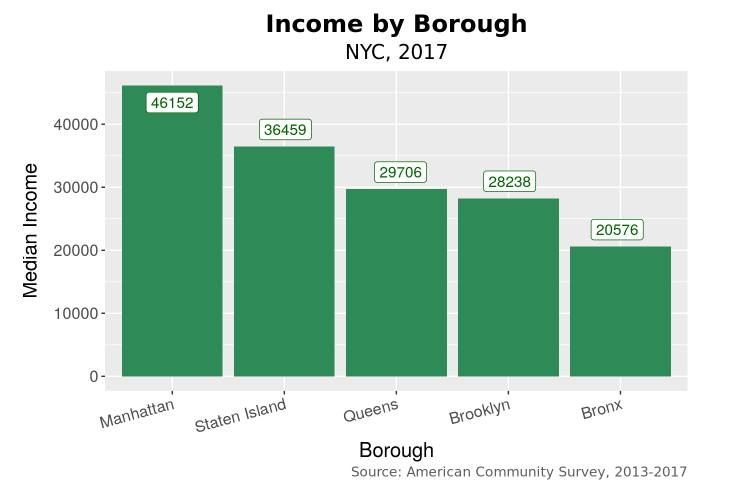

As I didn't have an access to the America Census API service, I have used the graph of EDA at https://www.rpubs.com/AnnmarieJenny/539613

One of the biggest factor which influences the serious crime rate might be the living status of the people living in the borough. So based on my human insight, I have found the graph of median income of each boroughs. As shown in the graph, the income of the Bronx is the lowest and the income in Manhattan is the highest, which is same with the Total Violent Crime Ratio. Although the data point is small, but still we can run correlation analysis with this.

In [38]:
TVC=total_violent_ratio_df.T
TVC['AVG'] = TVC.mean(axis=1)
TVC = TVC['AVG']
print(TVC)
Income = pd.Series([46152,36459,29706,28238,20576], index=['Manhattan','Staten Island','Queens','Brooklyn','Bronx'])
print(Income)
Income_Crime = pearsonr(TVC,Income)
print(Income_Crime)

Bronx            0.358543
Brooklyn         0.301903
Manhattan        0.179372
Queens           0.268853
Staten Island    0.236687
Name: AVG, dtype: float64
Manhattan        46152
Staten Island    36459
Queens           29706
Brooklyn         28238
Bronx            20576
dtype: int64
(0.7671741128398614, 0.1300468227998479)


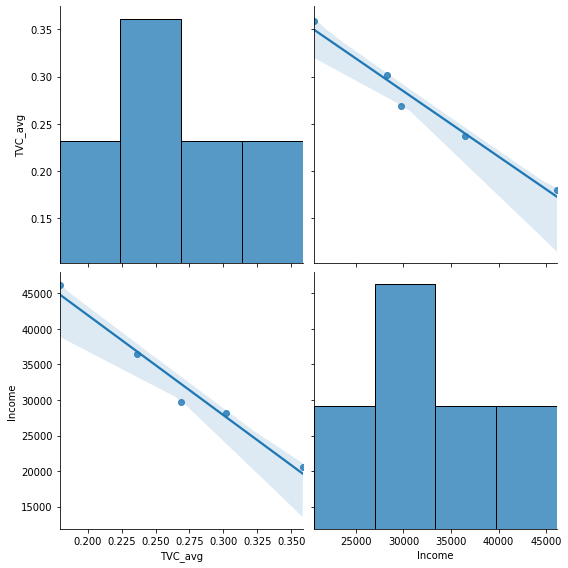

In [39]:
ICdf = pd.DataFrame([TVC,Income])
ICdf.rename(index={'AVG':'TVC_avg','Unnamed 0':'Income'},inplace=True)
ICdf = ICdf.T
sns.pairplot(data=ICdf,kind='reg',height=4)

Looking at the correlation coefficient and scatter plot with regression fitted line, although there are not enough data, we can still be more confident that income is determining factor of the Total Violent Crime ratio.

In [40]:
# Print lists of unique values of each Columns
rodent_col_list=ny_rodent.columns.to_list()
rodent_col_list

for i in rodent_col_list:
  print(i)
  print(ny_rodent[i].unique())
  print('\n')

INSPECTION_TYPE
['INITIAL' 'COMPLIANCE' 'BAIT' 'CLEAN_UPS']


BORO_CODE
[3 4 5 2 1]


BOROUGH
['Brooklyn' 'Queens' 'Staten Island' 'Bronx' 'Manhattan']


LATITUDE
[40.70613886 40.67226222 40.5588251  ... 40.70313616 40.62738595
 40.75879584]


LONGITUDE
[-73.93553579 -73.84571513 -74.12297854 ... -73.900998   -73.91491567
 -73.90920273]


ZIP_CODE
[11206 11417 10306 11214 10454 10312 11209 10305 11236 11357 10455 10466
 10470 10463 10014 10451 11230 11422 10314 10301 10304 10303 10009 11373
 11432 10310 11415 11413 10309 11355 10453 11434 11691 10012 10002 11223
 10469 10467 11358 10307 11385 10473 11693 10035 11212 11433 10022 11216
 10461 11379 10032 11429 10308 11414 10302 11224 11377 10456 10025 10471
 11231 10003 10457 11421 11234 11435 11374 11372 10023 11423 11378 11418
 10468 10024 10475 11375 11226 11369 11436 10027 11205 11411 11364 10001
 11213 10033 11419 11249 10034 10460 11215 11427 11104 10459 10458 10040
 11220 11238 11101 11420 11217 11239 10004 11235 10010 11218 11225

Looking at the unique values in the ZIP Code in the ny_rodent data, there are some values which is not a zip code of New York City. Zip Code = 10000 is not existing, and Zip Code = 12345 is a Zip Code of Schenectady, NY, which is not a neighborhood in New York City, so we should drop them out.


In [41]:
# Locate index values of data containing Zip Code of 10000 and 12345 for future drop proccess
zipcode_10000 = ny_rodent[ny_rodent.ZIP_CODE==10000].index.values
zipcode_12345 = ny_rodent[ny_rodent.ZIP_CODE==12345].index.values
print(zipcode_10000)
print(zipcode_12345)

# Drop Values
ny_rodent.drop(zipcode_10000, axis=0, inplace=True)
ny_rodent.drop(zipcode_12345, axis=0, inplace=True)

[ 87795 117525]
[ 299627  311378  322114  323467  375149  403815  511571  546224  569279
  678927  684288  695744  769436  822523  843257  857583  932489  958516
 1016331 1018755 1029584 1037962 1045641 1058674 1118994 1124912 1225955
 1266890 1294677 1308004 1320170 1327361 1341089 1354026 1411882 1450125
 1453166 1453194 1471029 1475900 1519625 1537729 1567007 1596480 1682525
 1685217 1688550 1704817 1740728 1771140]


In [42]:
# Check type whether it is Series or not
print(type(Zip_Code_checker))
print(type(ny_rodent.ZIP_CODE))

# Check the shape of the Series to look if it's plausible for future merging
print(Zip_Code_checker.unique().shape)
print(ny_rodent.ZIP_CODE.unique().shape)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
(336,)
(224,)


In [43]:
# Set variables to compare the unique values(Need to make sure that all the unique values of ny_rodent['ZIP_CODE'] should be in unique values of Zip_Code_checker)

a=Zip_Code_checker.unique()
a=a.tolist()
a = [int(i) for i in a]
print(type(a))
print(len(a))
print(a)

b = ny_rodent.ZIP_CODE.unique()
b=b.tolist()
b = [int(i) for i in b]
print(type(b))
print(len(b))
print(b)


<class 'list'>
336
[10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10043, 10044, 10045, 10046, 10047, 10048, 10055, 10060, 10065, 10069, 10072, 10075, 10079, 10080, 10081, 10082, 10087, 10090, 10094, 10095, 10096, 10098, 10099, 10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118, 10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10128, 10129, 10130, 10131, 10132, 10133, 10138, 10149, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10157, 10158, 10159, 10160, 10161, 10162, 10163, 10164, 10165, 10166, 10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10179, 10184, 10185, 10196, 10197, 10199, 10203, 10211, 10212, 10213, 10242, 10249, 10256, 

In [44]:
# Check if the variables in ny_rodent fits in tothe nyc_zips data
merged_ba = []
unmerged_ba = []

for i in b:
  if i in a:
    merged_ba.append(i)
  else:
    unmerged_ba.append(i)

print(len(b))
print(len(a))
print(len(merged_ba))
print(len(unmerged_ba))
print(unmerged_ba)

# Check how many & Which dataset in nyc_zips don't fit into ny_rodent data
merged_ab = []
unmerged_ab = []
for i in a:
  if i in b:
    merged_ab.append(i)
  else:
    unmerged_ab.append(i)

print(len(merged_ab))
print(len(unmerged_ab))
print(unmerged_ab)

224
336
224
0
[]
224
112
[10008, 10015, 10043, 10046, 10047, 10048, 10060, 10072, 10079, 10080, 10081, 10082, 10087, 10090, 10094, 10095, 10096, 10098, 10099, 10101, 10102, 10104, 10107, 10108, 10109, 10111, 10113, 10114, 10116, 10117, 10124, 10125, 10126, 10129, 10130, 10131, 10132, 10133, 10138, 10149, 10150, 10156, 10157, 10159, 10160, 10161, 10163, 10164, 10166, 10175, 10179, 10184, 10185, 10196, 10197, 10199, 10203, 10211, 10212, 10213, 10242, 10249, 10256, 10257, 10258, 10259, 10260, 10261, 10265, 10268, 10269, 10270, 10272, 10273, 10274, 10275, 10276, 10277, 10285, 10286, 10292, 10311, 10313, 10499, 11120, 11202, 11240, 11243, 11244, 11245, 11247, 11248, 11252, 11254, 11255, 11256, 11351, 11352, 11359, 11371, 11380, 11381, 11386, 11390, 11405, 11424, 11425, 11431, 11439, 11451, 11499, 11690]


In [45]:
# Drop rows which is not included in the merged cell

# Define function which changes Zip Code values to index values
def zip_to_idx(zipnum):
  idx=nyc_zips[nyc_zips['Zip Code']==zipnum].index.values.astype(int)[0]
  return idx

# test
print(zip_to_idx(10008))
print(nyc_zips.loc[10])

# Create index list
idx_list=[zip_to_idx(i) for i in unmerged_ab]
idx_list

# Drop rows
nyc_zips.drop(idx_list,axis=0,inplace=True)

# Check Final Output
nyc_zips['Zip Code'].unique().shape

10
Zip Code       10008
City        New York
County      New York
Name: 10, dtype: object


(224,)

In [46]:
# Change Column names and drop unnecessary feature for future merging proccess
nyc_zips_formerge = nyc_zips.rename(columns={'Zip Code': 'ZIP_CODE', 'County':'BOROUGH'})
nyc_zips_formerge.drop('City', axis=1, inplace=True)

# Merge nyc_zip dataframe and ny_rodent data on 'ZIP_CODE' and check whether it is merged correctly
ny_rodent_zip = pd.merge(ny_rodent, nyc_zips_formerge, how = 'outer', on='ZIP_CODE')
print(ny_rodent_zip.columns)

Index(['INSPECTION_TYPE', 'BORO_CODE', 'BOROUGH_x', 'LATITUDE', 'LONGITUDE',
       'ZIP_CODE', 'RESULT', 'YEAR', 'BOROUGH_y'],
      dtype='object')


In [47]:
'''for column in ny_rodent_zip.columns:
  print(ny_rodent_zip[f'{column}'].unique())
  print('\n')'''

"for column in ny_rodent_zip.columns:\n  print(ny_rodent_zip[f'{column}'].unique())\n  print('\n')"

In [48]:
ny_rodent_zip.INSPECTION_TYPE.replace(np.nan,'CLEAN',inplace=True)
ny_rodent_zip.RESULT.replace(np.nan, 'CLEAN',inplace=True)

In [49]:
# Change the name of the values from 'Kings','New York','Nassau','Richmond' to 'Brooklyn','Manhattan','Queens','Staten Island'
ny_rodent_zip.BOROUGH_y.replace(['Kings','New York','Nassau','Richmond'],['Brooklyn','Manhattan','Queens','Staten Island'], inplace=True)
ny_rodent_zip.drop('BOROUGH_x', axis=1, inplace=True)

# Rename Column
ny_rodent_zip.rename(columns={'BOROUGH_y':'BOROUGH'},inplace=True)

ny_rodent_zip.head()

INSPECTION_TYPE  BORO_CODE   LATITUDE  LONGITUDE  ZIP_CODE  \
0         INITIAL          3  40.706139 -73.935536     11206   
1         INITIAL          3  40.698160 -73.936423     11206   
2      COMPLIANCE          3  40.706139 -73.935536     11206   
3         INITIAL          3  40.706496 -73.935629     11206   
4         INITIAL          3  40.706242 -73.939117     11206   

               RESULT  YEAR   BOROUGH  
0    Active Rat Signs  2017  Brooklyn  
1   Passed Inspection  2017  Brooklyn  
2  Problem Conditions  2017  Brooklyn  
3   Passed Inspection  2018  Brooklyn  
4  Problem Conditions  2018  Brooklyn

In [50]:
# Some place shares same borough code but is in different borughs
ny_rodent_zip[ny_rodent_zip.BORO_CODE==1.0]

INSPECTION_TYPE  BORO_CODE   LATITUDE  LONGITUDE  ZIP_CODE  \
86074           INITIAL          1  40.873693 -73.908148     10463   
86075           INITIAL          1  40.876056 -73.912260     10463   
86077        COMPLIANCE          1  40.876056 -73.912260     10463   
86081        COMPLIANCE          1  40.876596 -73.910553     10463   
86082           INITIAL          1  40.876596 -73.910553     10463   
...                 ...        ...        ...        ...       ...   
1796580         INITIAL          1  40.758164 -73.973245     10154   
1796581         INITIAL          1  40.758164 -73.973245     10154   
1796582         INITIAL          1  40.764099 -73.973128     10153   
1796583         INITIAL          1  40.764013 -73.973189     10153   
1796584         INITIAL          1  40.764013 -73.973189     10153   

                     RESULT  YEAR    BOROUGH  
86074      Active Rat Signs  2018      Bronx  
86075      Active Rat Signs  2018      Bronx  
86077      Active Rat Signs  2018      Bronx  
86081     Passed Inspection  2018      Bronx  
86082    Problem Conditions  2018      Bronx  
...                     ...   ...        ...  
1796580   Passed Inspection  2012  Manhattan  
1796581   Passed Inspection  2011  Manhattan  
1796582   Passed Inspection  2009  Manhattan  
1796583   Passed Inspection  2019  Manhattan  
1796584   Passed Inspection  2018  Manhattan  

[586203 rows x 8 columns]

In [51]:
# Change datatype of BORO_CODE into integer and run for loop to see if there are more overlapping areas.
ny_rodent_zip.BORO_CODE=ny_rodent_zip.BORO_CODE.astype(int)
for i in range (1,6):
  print(ny_rodent_zip[ny_rodent_zip['BORO_CODE']==i].BOROUGH.unique())

['Bronx' 'Manhattan']
['Bronx']
['Brooklyn' 'Queens']
['Queens']
['Staten Island']


As seen in the result on the cell above, BORO_CODE==1 and BORO_CODE==3 contains two boroughs. Let's see the specific zip code of that area, and see if there's something special on this area.

In [52]:
# BORO_CODE == 1 and BOROUGH=='Bronx'
print(f'Zip Code of location with Borough code of 1 but in Bronx: {ny_rodent_zip[(ny_rodent_zip.BORO_CODE==1)&(ny_rodent_zip.BOROUGH=="Bronx")].ZIP_CODE.unique()[0]}')
ny_rodent_zip[(ny_rodent_zip.BORO_CODE==1)&(ny_rodent_zip.BOROUGH=='Bronx')]

Zip Code of location with Borough code of 1 but in Bronx: 10463


INSPECTION_TYPE  BORO_CODE   LATITUDE  LONGITUDE  ZIP_CODE  \
86074         INITIAL          1  40.873693 -73.908148     10463   
86075         INITIAL          1  40.876056 -73.912260     10463   
86077      COMPLIANCE          1  40.876056 -73.912260     10463   
86081      COMPLIANCE          1  40.876596 -73.910553     10463   
86082         INITIAL          1  40.876596 -73.910553     10463   
...               ...        ...        ...        ...       ...   
97441         INITIAL          1  40.877037 -73.910162     10463   
97528         INITIAL          1  40.876640 -73.911522     10463   
97533         INITIAL          1  40.874378 -73.910122     10463   
97544         INITIAL          1  40.874865 -73.911701     10463   
97547         INITIAL          1  40.876473 -73.911732     10463   

                   RESULT  YEAR BOROUGH  
86074    Active Rat Signs  2018   Bronx  
86075    Active Rat Signs  2018   Bronx  
86077    Active Rat Signs  2018   Bronx  
86081   Passed Inspection  2018   Bronx  
86082  Problem Conditions  2018   Bronx  
...                   ...   ...     ...  
97441   Passed Inspection  2011   Bronx  
97528   Passed Inspection  2010   Bronx  
97533   Passed Inspection  2011   Bronx  
97544    Active Rat Signs  2018   Bronx  
97547   Passed Inspection  2010   Bronx  

[578 rows x 8 columns]

In [53]:
# BORO_CODE == 3 and BOROUGH=='Queens'
print(f'Zip Code of location with Borough code of 3 but in Queens: {ny_rodent_zip[(ny_rodent_zip.BORO_CODE==3) & (ny_rodent_zip.BOROUGH=="Queens")].ZIP_CODE.unique()[0]}')
ny_rodent_zip[(ny_rodent_zip.BORO_CODE==3) & (ny_rodent_zip.BOROUGH=='Queens')]

Zip Code of location with Borough code of 3 but in Queens: 11416


INSPECTION_TYPE  BORO_CODE  LATITUDE  LONGITUDE  ZIP_CODE  \
1641432         INITIAL          3  40.68228 -73.864383     11416   
1641609         INITIAL          3  40.68231 -73.864271     11416   
1641865         INITIAL          3  40.68234 -73.864163     11416   
1641928         INITIAL          3  40.68225 -73.864491     11416   

                    RESULT  YEAR BOROUGH  
1641432  Passed Inspection  2012  Queens  
1641609  Passed Inspection  2012  Queens  
1641865  Passed Inspection  2012  Queens  
1641928  Passed Inspection  2012  Queens

In [54]:
# Checking unique values for Future Exploration
for i in ny_rodent_zip.columns:
  print(f'{i}\n{ny_rodent_zip[i].unique()}\n')

# Preprocessing
ny_rodent_zip.BORO_CODE.replace(np.nan,0,inplace=True)
ny_rodent_zip.BORO_CODE.unique()

zero_index = ny_rodent_zip[ny_rodent_zip.BORO_CODE==0].index
zero_Borough = ny_rodent_zip[ny_rodent_zip.BORO_CODE==0].BOROUGH.values
Borough_index = ['Manhattan','Bronx','Brooklyn','Queens','Staten Island']

a=0
while a < 5:
  for i, e in zip(zero_index ,zero_Borough):
    if ny_rodent_zip.loc[i,'BOROUGH'] == Borough_index[a]:
      ny_rodent_zip.loc[i,'BORO_CODE'] = a+1
  a+=1

print(ny_rodent_zip.LATITUDE.isna().sum())
print(ny_rodent_zip.LONGITUDE.isna().sum())

ny_rodent_zip.LONGITUDE.isna()

#ny_rodent_zip.loc[1796696,'LONGITUDE']

INSPECTION_TYPE
['INITIAL' 'COMPLIANCE' 'BAIT' 'CLEAN_UPS']

BORO_CODE
[3 4 5 2 1]

LATITUDE
[40.70613886 40.6981603  40.70649573 ... 40.75816441 40.76409855
 40.76401348]

LONGITUDE
[-73.93553579 -73.93642349 -73.93562922 ... -73.97324549 -73.97312758
 -73.97318899]

ZIP_CODE
[11206 11417 10306 11214 10454 10312 11209 10305 11236 11357 10455 10466
 10470 10463 10014 10451 11230 11422 10314 10301 10304 10303 10009 11373
 11432 10310 11415 11413 10309 11355 10453 11434 11691 10012 10002 11223
 10469 10467 11358 10307 11385 10473 11693 10035 11212 11433 10022 11216
 10461 11379 10032 11429 10308 11414 10302 11224 11377 10456 10025 10471
 11231 10003 10457 11421 11234 11435 11374 11372 10023 11423 11378 11418
 10468 10024 10475 11375 11226 11369 11436 10027 11205 11411 11364 10001
 11213 10033 11419 11249 10034 10460 11215 11427 11104 10459 10458 10040
 11220 11238 11101 11420 11217 11239 10004 11235 10010 11218 11225 11105
 11222 11207 11430 11208 10037 11211 10452 11210 11001 11365 1046

0          False
1          False
2          False
3          False
4          False
           ...  
1796580    False
1796581    False
1796582    False
1796583    False
1796584    False
Name: LONGITUDE, Length: 1796585, dtype: bool

In [55]:
c = geocoder.arcgis('11206, New York')
c.latlng

[40.70159000000007, -73.94334999999995]

In [56]:
#### Test Code for Function in the next cell ####

'''test = ny_rodent_zip.copy()
test[['LATITUDE','LONGITUDE']].fillna(0,inplace = True)
test[['LATITUDE','LONGITUDE']]=test[['LATITUDE','LONGITUDE']].replace(np.nan,0)
zero_lat_index = test[(test['LATITUDE']==0)].index
zero_lng_index = test[(test['LONGITUDE']==0)].index
test_zip_list=[]
for i in zero_lat_index:
  test_zip_list.append(test.loc[i,'ZIP_CODE'])
lat_test = []
lng_test = []
for i in test_zip_list:
  temp = geocoder.arcgis(f'{i}, New York')
  lat_lng = temp.latlng
  lat_test.append(lat_lng[0])
  lng_test.append(lat_lng[1])
  
print(len(lat_test))
print(len(lng_test))

test[['LATITUDE','LONGITUDE']].fillna(0,inplace = True)
zero_index = test[(test['LATITUDE']==0)].index
print(zero_index)
  '''

"test = ny_rodent_zip.copy()\ntest[['LATITUDE','LONGITUDE']].fillna(0,inplace = True)\ntest[['LATITUDE','LONGITUDE']]=test[['LATITUDE','LONGITUDE']].replace(np.nan,0)\nzero_lat_index = test[(test['LATITUDE']==0)].index\nzero_lng_index = test[(test['LONGITUDE']==0)].index\ntest_zip_list=[]\nfor i in zero_lat_index:\n  test_zip_list.append(test.loc[i,'ZIP_CODE'])\nlat_test = []\nlng_test = []\nfor i in test_zip_list:\n  temp = geocoder.arcgis(f'{i}, New York')\n  lat_lng = temp.latlng\n  lat_test.append(lat_lng[0])\n  lng_test.append(lat_lng[1])\n  \nprint(len(lat_test))\nprint(len(lng_test))\n\ntest[['LATITUDE','LONGITUDE']].fillna(0,inplace = True)\nzero_index = test[(test['LATITUDE']==0)].index\nprint(zero_index)\n  "

In [57]:
# Function to fill in latitude and longitude information for the area where latitude and logitude data were empty
def nan_to_latlng():
  zip_list=[]
  ny_rodent_zip[['LATITUDE','LONGITUDE']].fillna(0,inplace = True)
  ny_rodent_zip[['LATITUDE','LONGITUDE']]=ny_rodent_zip[['LATITUDE','LONGITUDE']].replace(np.nan,0)
  zero_index = ny_rodent_zip[(ny_rodent_zip['LATITUDE']==0)&(ny_rodent_zip['LONGITUDE']==0)].index
  for i in zero_index:
    zip_list.append(ny_rodent_zip.loc[i,'ZIP_CODE'])
  lat=[]
  lng=[]
  for i in zip_list:
    temp = geocoder.arcgis(f'{i}, New York')
    lat_lng = temp.latlng
    lat.append(lat_lng[0])
    lng.append(lat_lng[1])
  for i,j,k in zip(zero_index,lat,lng):
    ny_rodent_zip.loc[i,'LATITUDE']=j
    ny_rodent_zip.loc[i,'LONGITUDE']=k
  return ny_rodent_zip

In [58]:
nan_to_latlng()

print(ny_rodent_zip.LATITUDE.isna().sum())
print(ny_rodent_zip.LONGITUDE.isna().sum())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


0
0


In [59]:
'''for i in range(1,6):
  temp = ny_rodent_zip[ny_rodent_zip['BORO_CODE']==i]
  print(f'{i}\n{temp.head()}\n')'''

"for i in range(1,6):\n  temp = ny_rodent_zip[ny_rodent_zip['BORO_CODE']==i]\n  print(f'{i}\n{temp.head()}\n')"

In [60]:
# See if there's any difference between BORO_CODE and BOROUGH
temp = ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Manhattan']
print(len(temp['ZIP_CODE'].unique()))
print(temp['ZIP_CODE'].unique())

temp = ny_rodent_zip[ny_rodent_zip['BORO_CODE']==1]
print(len(temp['ZIP_CODE'].unique()))
print(temp['ZIP_CODE'].unique())

83
[10014 10009 10012 10002 10035 10022 10032 10025 10003 10023 10024 10027
 10001 10033 10034 10040 10004 10010 10037 10036 10065 10026 10029 10128
 10018 10038 10019 10016 10017 10006 10011 10005 10013 10030 10028 10039
 10007 10031 10075 10282 10021 10280 10069 10119 10020 10281 10105 10044
 10103 10162 10165 10173 10168 10170 10169 10055 10278 10174 10155 10115
 10271 10120 10118 10178 10112 10045 10123 10041 10172 10110 10279 10158
 10151 10121 10152 10122 10106 10177 10167 10176 10171 10154 10153]
84
[10463 10014 10009 10012 10002 10035 10022 10032 10025 10003 10023 10024
 10027 10001 10033 10034 10040 10004 10010 10037 10036 10065 10026 10029
 10128 10018 10038 10019 10016 10017 10006 10011 10005 10013 10030 10028
 10039 10007 10031 10075 10282 10021 10280 10069 10119 10020 10281 10105
 10044 10103 10162 10165 10173 10168 10170 10169 10055 10278 10174 10155
 10115 10271 10120 10118 10178 10112 10045 10123 10041 10172 10110 10279
 10158 10151 10121 10152 10122 10106 10177 10167 1

In [61]:
print(len(ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Manhattan'].ZIP_CODE.unique()))
print(ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Manhattan'].shape)

print(len(ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Bronx'].ZIP_CODE.unique()))
print(ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Bronx'].shape)

print(len(ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Brooklyn'].ZIP_CODE.unique()))
print(ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Brooklyn'].shape)

print(len(ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Queens'].ZIP_CODE.unique()))
print(ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Queens'].shape)

print(len(ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Staten Island'].ZIP_CODE.unique()))
print(ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Staten Island'].shape)

83
(585625, 8)
25
(541176, 8)
41
(452394, 8)
63
(169262, 8)
12
(48128, 8)


In [62]:
Borough_list[4]= 'Staten Island'
for i in Borough_list:
  print(len(ny_rodent_zip[ny_rodent_zip['BOROUGH']==i].ZIP_CODE.unique()))
  print(ny_rodent_zip[ny_rodent_zip['BOROUGH']==i].shape)

83
(585625, 8)
25
(541176, 8)
41
(452394, 8)
63
(169262, 8)
12
(48128, 8)


In [63]:
# Create table which counts the inspection result grouped by BOROUGH
ny_rodent_zip_grouped1 = ny_rodent_zip.groupby(['BOROUGH','INSPECTION_TYPE'])
ny_rodent_zip1 = ny_rodent_zip_grouped1.RESULT.count().reset_index()
ny_rodent_zip1.set_index(['BOROUGH','INSPECTION_TYPE'],inplace=True)
ny_rodent_zip1=ny_rodent_zip1.reindex(['Manhattan','Bronx','Brooklyn','Queens','Staten Island'], level='BOROUGH')
ny_rodent_zip1=ny_rodent_zip1.reindex(['INITIAL', 'COMPLIANCE', 'BAIT','CLEAN_UPS','CLEAN'], level='INSPECTION_TYPE')
ny_rodent_zip1

RESULT
BOROUGH       INSPECTION_TYPE        
Manhattan     INITIAL          444562
              COMPLIANCE        53593
              BAIT              87360
              CLEAN_UPS           110
Bronx         INITIAL          381311
              COMPLIANCE        78025
              BAIT              81353
              CLEAN_UPS           487
Brooklyn      INITIAL          301342
              COMPLIANCE        70933
              BAIT              79572
              CLEAN_UPS           547
Queens        INITIAL          111248
              COMPLIANCE        37625
              BAIT              20034
              CLEAN_UPS           355
Staten Island INITIAL           29409
              COMPLIANCE        13830
              BAIT               4871
              CLEAN_UPS            18

In [64]:
ny_rodent_zip[ny_rodent_zip['BOROUGH']=='Manhattan'].ZIP_CODE.unique()

array([10014, 10009, 10012, 10002, 10035, 10022, 10032, 10025, 10003,
       10023, 10024, 10027, 10001, 10033, 10034, 10040, 10004, 10010,
       10037, 10036, 10065, 10026, 10029, 10128, 10018, 10038, 10019,
       10016, 10017, 10006, 10011, 10005, 10013, 10030, 10028, 10039,
       10007, 10031, 10075, 10282, 10021, 10280, 10069, 10119, 10020,
       10281, 10105, 10044, 10103, 10162, 10165, 10173, 10168, 10170,
       10169, 10055, 10278, 10174, 10155, 10115, 10271, 10120, 10118,
       10178, 10112, 10045, 10123, 10041, 10172, 10110, 10279, 10158,
       10151, 10121, 10152, 10122, 10106, 10177, 10167, 10176, 10171,
       10154, 10153])

In [65]:
### # of ZIP_CODES on each Boroughs ###

'''BOROUGH_len = []
BORO_CODE_len = []
borough = ['Manhattan','Bronx','Brooklyn','Queens','Staten Island']

for i in borough:
  temp = ny_rodent_zip[ny_rodent_zip['BOROUGH']==i]
  BOROUGH_len.append(len(temp['ZIP_CODE'].unique()))

for i in range(1,6):
  temp = ny_rodent_zip[ny_rodent_zip['BORO_CODE']==i]
  BORO_CODE_len.append(len(temp['ZIP_CODE'].unique()))

print(BOROUGH_len)
print(BORO_CODE_len)'''

"BOROUGH_len = []\nBORO_CODE_len = []\nborough = ['Manhattan','Bronx','Brooklyn','Queens','Staten Island']\n\nfor i in borough:\n  temp = ny_rodent_zip[ny_rodent_zip['BOROUGH']==i]\n  BOROUGH_len.append(len(temp['ZIP_CODE'].unique()))\n\nfor i in range(1,6):\n  temp = ny_rodent_zip[ny_rodent_zip['BORO_CODE']==i]\n  BORO_CODE_len.append(len(temp['ZIP_CODE'].unique()))\n\nprint(BOROUGH_len)\nprint(BORO_CODE_len)"

In [66]:
# Create table which counts the inspection result grouped by BORO_CODE

ny_rodent_zip_grouped2 = ny_rodent_zip.groupby(['BORO_CODE','INSPECTION_TYPE'])
ny_rodent_zip2 = ny_rodent_zip_grouped2.RESULT.count().reset_index()
ny_rodent_zip2.set_index(['BORO_CODE','INSPECTION_TYPE'],inplace=True)
ny_rodent_zip2=ny_rodent_zip2.reindex(['INITIAL', 'COMPLIANCE', 'BAIT','CLEAN_UPS','CLEAN'], level='INSPECTION_TYPE')
ny_rodent_zip2

RESULT
BORO_CODE INSPECTION_TYPE        
1         INITIAL          445058
          COMPLIANCE        53646
          BAIT              87387
          CLEAN_UPS           112
2         INITIAL          380815
          COMPLIANCE        77972
          BAIT              81326
          CLEAN_UPS           485
3         INITIAL          301346
          COMPLIANCE        70933
          BAIT              79572
          CLEAN_UPS           547
4         INITIAL          111244
          COMPLIANCE        37625
          BAIT              20034
          CLEAN_UPS           355
5         INITIAL           29409
          COMPLIANCE        13830
          BAIT               4871
          CLEAN_UPS            18

In [67]:
# Add a column which calculates rodents/km2 ratio
ny_rodent_zip1_ratio = ny_rodent_zip1.copy()
BOROUGH_AREA = [59.1, 110, 180, 280, 152]
Blen=[]
for i in BOROUGH_AREA:
  for j in range(4):
    Blen.append(i)

ny_rodent_zip1_ratio['Rodents/ km2'] = ny_rodent_zip1_ratio['RESULT'] / Blen
ny_rodent_zip1_ratio

RESULT  Rodents/ km2
BOROUGH       INSPECTION_TYPE                      
Manhattan     INITIAL          444562   7522.199662
              COMPLIANCE        53593    906.818951
              BAIT              87360   1478.172589
              CLEAN_UPS           110      1.861252
Bronx         INITIAL          381311   3466.463636
              COMPLIANCE        78025    709.318182
              BAIT              81353    739.572727
              CLEAN_UPS           487      4.427273
Brooklyn      INITIAL          301342   1674.122222
              COMPLIANCE        70933    394.072222
              BAIT              79572    442.066667
              CLEAN_UPS           547      3.038889
Queens        INITIAL          111248    397.314286
              COMPLIANCE        37625    134.375000
              BAIT              20034     71.550000
              CLEAN_UPS           355      1.267857
Staten Island INITIAL           29409    193.480263
              COMPLIANCE        13830     90.986842
              BAIT               4871     32.046053
              CLEAN_UPS            18      0.118421

In [68]:
# Load population data from wikipedia, drop axis and only extract a series that contains population per km2 
nyc_population = pd.read_html('https://en.wikipedia.org/wiki/Boroughs_of_New_York_City')
nyc_population = nyc_population[0]
nyc_population.columns = nyc_population.columns.droplevel()
nyc_population.columns = nyc_population.columns.droplevel()
nyc_population.drop([5,6,7],axis=0,inplace=True)
nyc_population.set_index('Borough', inplace=True)
nyc_population.rename(columns={'persons /km2':'people/km2'},inplace=True)
nyc_population = nyc_population['people/km2']
nyc_population.rename(index={'The Bronx':'Bronx'},inplace=True)
nyc_population= nyc_population.reindex(['Manhattan','Bronx','Brooklyn','Queens','Staten Island'])

nyc_population.rename_axis('BOROUGH',inplace=True)
nyc_population

BOROUGH
Manhattan        27544
Bronx            13006
Brooklyn         13957
Queens            8018
Staten Island     3150
Name: people/km2, dtype: object

In [69]:
ny_rz1r = ny_rodent_zip1_ratio.reset_index('INSPECTION_TYPE')
rz1r_initial=ny_rz1r[ny_rz1r['INSPECTION_TYPE']=='INITIAL']
ny_rod_pop=pd.merge(rz1r_initial,nyc_population,how='inner',on='BOROUGH')
ny_rod_pop

INSPECTION_TYPE  RESULT  Rodents/ km2 people/km2
BOROUGH                                                       
Manhattan             INITIAL  444562   7522.199662      27544
Bronx                 INITIAL  381311   3466.463636      13006
Brooklyn              INITIAL  301342   1674.122222      13957
Queens                INITIAL  111248    397.314286       8018
Staten Island         INITIAL   29409    193.480263       3150

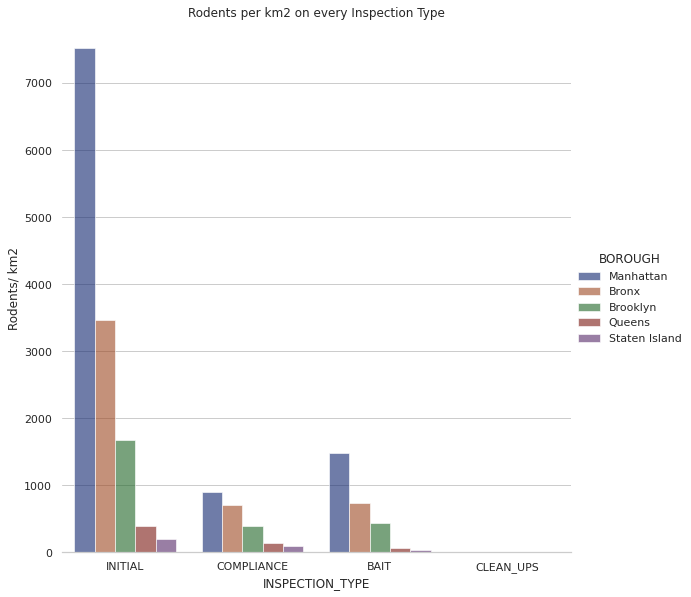

In [70]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.catplot(
  data=ny_rz1r.reset_index(), kind="bar",
  x="INSPECTION_TYPE", y="Rodents/ km2", hue="BOROUGH",
  ci="sd", palette="dark", alpha=.6, height=8)
plt.title('Rodents per km2 on every Inspection Type')
sns.despine(left=True)

Manhattan has the most rodent inspected and they run more inspection as well. It's hard to see the effort of each borough dealing with the rodents, so let's look more into the data by calculating the ratio of Initial and Bait.

In [71]:
# Print the shape of the filtered dataframe and get unique values returned
ny_rodent_initial = ny_rodent[ny_rodent['INSPECTION_TYPE']=='INITIAL']
ny_rodent_execute = ny_rodent[ny_rodent['INSPECTION_TYPE']=='BAIT']
print(ny_rodent_initial.shape)
print(ny_rodent_initial.RESULT.unique())
print(ny_rodent_execute.shape)
print(ny_rodent_execute.RESULT.unique())

(1267872, 8)
['Active Rat Signs' 'Passed Inspection' 'Problem Conditions']
(273190, 8)
['Monitoring visit' 'Bait applied']


On the values of Initial stage, it's hard to say wich variable is irrelevant, assuming that all of the values are valid. However, we are sure that the Monitoring Visit doesn't really change the situation better, I will drop the values which contains Monitoring visit. 

In [72]:
# Values of counts of each values (Initial)
ny_rodent_initial_grouped = ny_rodent_initial.groupby(['BOROUGH'])
initial_value = []
for key, group in ny_rodent_initial_grouped:
  initial_value.append(len(group))

print(initial_value)

[380815, 301346, 445058, 111244, 29409]


In [73]:
print(ny_rodent_execute.shape)
print(ny_rodent_execute.RESULT.unique())
ny_rodent_execute.head()

(273190, 8)
['Monitoring visit' 'Bait applied']


INSPECTION_TYPE  BORO_CODE BOROUGH   LATITUDE  LONGITUDE  ZIP_CODE  \
16             BAIT          2   Bronx  40.901165 -73.861981     10470   
38             BAIT          2   Bronx  40.889942 -73.833048     10466   
69             BAIT          2   Bronx  40.889942 -73.833048     10466   
177            BAIT          2   Bronx  40.841235 -73.910387     10457   
185            BAIT          2   Bronx  40.878299 -73.834944     10475   

               RESULT  YEAR  
16   Monitoring visit  2017  
38       Bait applied  2017  
69       Bait applied  2017  
177      Bait applied  2017  
185      Bait applied  2018

In [74]:
ny_rodent_execute =ny_rodent_execute[['BORO_CODE','BOROUGH','LATITUDE','LONGITUDE','ZIP_CODE','RESULT']]
ny_rodent_execute.head()

BORO_CODE BOROUGH   LATITUDE  LONGITUDE  ZIP_CODE            RESULT
16           2   Bronx  40.901165 -73.861981     10470  Monitoring visit
38           2   Bronx  40.889942 -73.833048     10466      Bait applied
69           2   Bronx  40.889942 -73.833048     10466      Bait applied
177          2   Bronx  40.841235 -73.910387     10457      Bait applied
185          2   Bronx  40.878299 -73.834944     10475      Bait applied

In [75]:
# filter the dataframe with the bait applied result
ny_rodent_real_execute = ny_rodent_execute[ny_rodent_execute.RESULT=='Bait applied']
print(ny_rodent_execute.shape[0])
print(ny_rodent_real_execute.shape[0])

273190
241963


In [76]:
ny_rodent_real_execute.grouped = ny_rodent_real_execute.groupby('BOROUGH')
execute_value=[]
for key, group in ny_rodent_real_execute.grouped:
  print(key)
  execute_value.append(len(group))
  print(len(group))

Bronx
77005
Brooklyn
65021
Manhattan
77093
Queens
18662
Staten Island
4182


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [77]:
print(initial_value)
print(execute_value)

[380815, 301346, 445058, 111244, 29409]
[77005, 65021, 77093, 18662, 4182]


In [78]:
initial_execute_ratio=[]
for i,j in zip(initial_value,execute_value):
  initial_execute_ratio.append(i/j)
initial_execute_ratio

[4.945328225439907,
 4.634594977007429,
 5.7730014398194385,
 5.960990247561891,
 7.032281205164993]

As Manhattan and Bronx are the top 2 boroughs with initial inspection of rodents, they have releatively lower initial/bait result. Still it's interesting to find that Bronx borough, the poorest borough, is reacting  better on rodent baiting than Manhattan, the richest borough.

In [79]:
CLIENT_ID = 'PFLOX213BMMMYSNWYKQQTGWUSOMMDFKOHMPOQWBORAOVYQKF' # your Foursquare ID
CLIENT_SECRET = '31NZZLA4RFCQ1W4YYMIH0D4TN3TAHIH25L5QWWPTKYGR3IYQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
ACCESS_TOKEN = 'NAFRGVYU1IRV1PAQF4ZKDD5UOKJULRS003J4PHNZSKIW3TWJ'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PFLOX213BMMMYSNWYKQQTGWUSOMMDFKOHMPOQWBORAOVYQKF
CLIENT_SECRET:31NZZLA4RFCQ1W4YYMIH0D4TN3TAHIH25L5QWWPTKYGR3IYQ


In [80]:
ny_rodent_zip.head()

INSPECTION_TYPE  BORO_CODE   LATITUDE  LONGITUDE  ZIP_CODE  \
0         INITIAL          3  40.706139 -73.935536     11206   
1         INITIAL          3  40.698160 -73.936423     11206   
2      COMPLIANCE          3  40.706139 -73.935536     11206   
3         INITIAL          3  40.706496 -73.935629     11206   
4         INITIAL          3  40.706242 -73.939117     11206   

               RESULT  YEAR   BOROUGH  
0    Active Rat Signs  2017  Brooklyn  
1   Passed Inspection  2017  Brooklyn  
2  Problem Conditions  2017  Brooklyn  
3   Passed Inspection  2018  Brooklyn  
4  Problem Conditions  2018  Brooklyn

In [81]:
%whos DataFrame


Variable                         Type         Data/Info
-------------------------------------------------------
Bronx_Crime_Rodent               DataFrame          Bronx_Total_Crime  <...>      35355         43833
Bronx_TVCRatio_Rodent            DataFrame          Bronx_TVC_Ratio  Br<...>   0.353953         43833
Bronx_Zip                        DataFrame        Zip Code   City Count<...>04    10499  Bronx  Bronx
Bronx_crime                      DataFrame          Bronx Total\nYear  <...> 35507\n2018        35355
Bronx_violent                    DataFrame          Bronx Violent\nYear<...>2534\n2018          12514
Brooklyn_Crime_Rodent            DataFrame          Brooklyn_Total_Crim<...>   50106            63804
Brooklyn_TVCRatio_Rodent         DataFrame          Brooklyn_TVC_Ratio <...>0.287071            63804
Brooklyn_Zip                     DataFrame        Zip Code      City Co<...>   11256  Brooklyn  Kings
Brooklyn_crime                   DataFrame          Brooklyn Total\nYea<

In [82]:
nyc_zips

Zip Code           City    County
3       10001       New York  New York
4       10002       New York  New York
5       10003       New York  New York
6       10004       New York  New York
7       10005       New York  New York
..        ...            ...       ...
568     11692        Arverne    Queens
569     11693   Far Rockaway    Queens
570     11694  Rockaway Park    Queens
571     11695   Far Rockaway    Queens
572     11697   Breezy Point    Queens

[224 rows x 3 columns]

In [83]:
# Create a Dataframe containing ZIP_CODE information
nyc_zips_geoinfo = nyc_zips_formerge.copy()
nyc_zips_geoinfo.replace(['Kings','New York','Nassau','Richmond'],['Brooklyn','Manhattan','Queens','Staten Island'], inplace = True)

# Retrieve latitude, longitude by geocoder
lat_lng = {}
for i,j in zip(nyc_zips_geoinfo.ZIP_CODE,range(nyc_zips_geoinfo.shape[0])):
  tmp = geocoder.arcgis(f'{i}, New York')
  lat_lng[j] = tmp.latlng

# Seperate latitude and longitude stored in dictionary
lat=[]
lng=[]
for i in lat_lng:
  lat.append(lat_lng[i][0])
  lng.append(lat_lng[i][1])

# Add latitude, longitude into geoinfo dataframe
nyc_zips_geoinfo['LATITUDE'] = np.array(lat)
nyc_zips_geoinfo['LONGITUDE'] = np.array(lng)

# Reset & drop index
nyc_zips_geoinfo.reset_index(inplace=True)
nyc_zips_geoinfo.drop('index',axis=1,inplace=True)

# Create new columns containing infor mation of ZIP_CODE and BOROUGH, then drop two columns
nyc_zips_geoinfo['Area'] = nyc_zips_geoinfo['BOROUGH'].astype(str) + ", " + nyc_zips_geoinfo['ZIP_CODE'].astype(str)
nyc_zips_geoinfo.drop(['ZIP_CODE','BOROUGH'],axis=1, inplace=True)
nyc_zips_geoinfo

LATITUDE  LONGITUDE              Area
0    40.750955 -73.998110  Manhattan, 10001
1    40.716475 -73.988450  Manhattan, 10002
2    40.732360 -73.989090  Manhattan, 10003
3    40.704027 -74.012205  Manhattan, 10004
4    40.705799 -74.007695  Manhattan, 10005
..         ...        ...               ...
219  40.592725 -73.797855     Queens, 11692
220  40.587490 -73.811680     Queens, 11693
221  40.573595 -73.857465     Queens, 11694
222  40.618160 -73.741250     Queens, 11695
223  40.560745 -73.917510     Queens, 11697

[224 rows x 3 columns]

In [84]:
### test cell
'''test = {}
nyc_zips_test = nyc_zips_formerge.copy()

tmp = geocoder.arcgis('11697, New York')
print(tmp.latlng)

for i,j in zip(nyc_zips_test.ZIP_CODE,range(nyc_zips_test.shape[0])):
  tmp = geocoder.arcgis(f'{i}, New York')
  test[j] = tmp.latlng

lat_test=[]
lng_test=[]
for i in test:
  lat_test.append(test[i][0])
  lng_test.append(test[i][1])

nyc_zips_test['LATITUDE'] = np.array(lat_test)
nyc_zips_test['LONGITUDE'] = np.array(lng_test)

print(nyc_zips_test.LATITUDE.isnull().sum())
print(nyc_zips_test.LONGITUDE.isnull().sum())
nyc_zips_test'''

"test = {}\nnyc_zips_test = nyc_zips_formerge.copy()\n\ntmp = geocoder.arcgis('11697, New York')\nprint(tmp.latlng)\n\nfor i,j in zip(nyc_zips_test.ZIP_CODE,range(nyc_zips_test.shape[0])):\n  tmp = geocoder.arcgis(f'{i}, New York')\n  test[j] = tmp.latlng\n\nlat_test=[]\nlng_test=[]\nfor i in test:\n  lat_test.append(test[i][0])\n  lng_test.append(test[i][1])\n\nnyc_zips_test['LATITUDE'] = np.array(lat_test)\nnyc_zips_test['LONGITUDE'] = np.array(lng_test)\n\nprint(nyc_zips_test.LATITUDE.isnull().sum())\nprint(nyc_zips_test.LONGITUDE.isnull().sum())\nnyc_zips_test"

In [92]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&oauth_token={ACCESS_TOKEN}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={LIMIT}'

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [93]:

NY_Venues=getNearbyVenues(names=nyc_zips_geoinfo['Area'],
                                   latitudes=nyc_zips_geoinfo['LATITUDE'],
                                   longitudes=nyc_zips_geoinfo['LONGITUDE']
                                  )

Manhattan, 10001
Manhattan, 10002
Manhattan, 10003
Manhattan, 10004
Manhattan, 10005
Manhattan, 10006
Manhattan, 10007
Manhattan, 10009
Manhattan, 10010
Manhattan, 10011
Manhattan, 10012
Manhattan, 10013
Manhattan, 10014
Manhattan, 10016
Manhattan, 10017
Manhattan, 10018
Manhattan, 10019
Manhattan, 10020
Manhattan, 10021
Manhattan, 10022
Manhattan, 10023
Manhattan, 10024
Manhattan, 10025
Manhattan, 10026
Manhattan, 10027
Manhattan, 10028
Manhattan, 10029
Manhattan, 10030
Manhattan, 10031
Manhattan, 10032
Manhattan, 10033
Manhattan, 10034
Manhattan, 10035
Manhattan, 10036
Manhattan, 10037
Manhattan, 10038
Manhattan, 10039
Manhattan, 10040
Manhattan, 10041
Manhattan, 10044
Manhattan, 10045
Manhattan, 10055
Manhattan, 10065
Manhattan, 10069
Manhattan, 10075
Manhattan, 10103
Manhattan, 10105
Manhattan, 10106
Manhattan, 10110
Manhattan, 10112
Manhattan, 10115
Manhattan, 10118
Manhattan, 10119
Manhattan, 10120
Manhattan, 10121
Manhattan, 10122
Manhattan, 10123
Manhattan, 10128
Manhattan, 101

In [94]:
print(NY_Venues.shape)
NY_Venues.head()

(17153, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Manhattan, 10001              40.750955               -73.99811   
1  Manhattan, 10001              40.750955               -73.99811   
2  Manhattan, 10001              40.750955               -73.99811   
3  Manhattan, 10001              40.750955               -73.99811   
4  Manhattan, 10001              40.750955               -73.99811   

                           Venue  Venue Latitude  Venue Longitude  \
0                 Bluestone Lane       40.752068       -73.998848   
1         New York Pizza Suprema       40.750124       -73.994992   
2            Moynihan Train Hall       40.751070       -73.994990   
3  Equinox+ In The Wild New York       40.752369       -74.000580   
4                B&H Photo Video       40.753277       -73.996470   

         Venue Category  
0           Coffee Shop  
1           Pizza Place  
2         Train Station  
3  Gym / Fitness Center  
4          Camera Store

In [96]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
NY_Venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                 
Bronx, 10451                             80                      80     80   
Bronx, 10452                             82                      82     82   
Bronx, 10453                             79                      79     79   
Bronx, 10454                             69                      69     69   
Bronx, 10455                             67                      67     67   
Bronx, 10456                             57                      57     57   
Bronx, 10457                             60                      60     60   
Bronx, 10458                             83                      83     83   
Bronx, 10459                             64                      64     64   
Bronx, 10460                             78                      78     78   
Bronx, 10461                             81                      81     81   
Bronx, 10462                             72                      72     72   
Bronx, 10463                             90                      90     90   
Bronx, 10464                             52                      52     52   
Bronx, 10465                             75                      75     75   
Bronx, 10466                             41                      41     41   
Bronx, 10467                             62                      62     62   
Bronx, 10468                             70                      70     70   
Bronx, 10469                             64                      64     64   
Bronx, 10470                             49                      49     49   
Bronx, 10471                             48                      48     48   
Bronx, 10472                             75                      75     75   
Bronx, 10473                             31                      31     31   
Bronx, 10474                             63                      63     63   
Bronx, 10475                             51                      51     51   
Brooklyn, 11201                         100                     100    100   
Brooklyn, 11203                          58                      58     58   
Brooklyn, 11204                          63                      63     63   
Brooklyn, 11205                          80                      80     80   
Brooklyn, 11206                          90                      90     90   
Brooklyn, 11207                          60                      60     60   
Brooklyn, 11208                          63                      63     63   
Brooklyn, 11209                         100                     100    100   
Brooklyn, 11210                          60                      60     60   
Brooklyn, 11211                         100                     100    100   
Brooklyn, 11212                          56                      56     56   
Brooklyn, 11213                          71                      71     71   
Brooklyn, 11214                          35                      35     35   
Brooklyn, 11215                         100                     100    100   
Brooklyn, 11216                         100                     100    100   
Brooklyn, 11217                         100                     100    100   
Brooklyn, 11218                          95                      95     95   
Brooklyn, 11219                          59                      59     59   
Brooklyn, 11220                          77                      77     77   
Brooklyn, 11221                          90                      90     90   
Brooklyn, 11222                         100                     100    100   
Brooklyn, 11223                          63                      63     63   
Brooklyn, 11224                          85                      85     85   
Brooklyn, 11225                          64                      64     64   
Brooklyn, 11226                          92 

In [97]:
NY_Venue_count=len(NY_Venues['Venue Category'].unique())
print(f'There are {NY_Venue_count} uniques categories.')

There are 479 uniques categories.


In [99]:
# one hot encoding
NY_onehot = pd.get_dummies(NY_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot['Neighborhood'] = NY_Venues['Neighborhood']
onehot_list=NY_onehot.columns.tolist()
index=onehot_list.index('Neighborhood')
index

# move neighborhood column to the first column
onehot_list =onehot_list[index:index+1] + onehot_list[:index] + onehot_list[index+1:]
NY_onehot = NY_onehot[onehot_list]


NY_onehot.head()

Neighborhood  ATM  Accessories Store  Adult Boutique  \
0  Manhattan, 10001    0                  0               0   
1  Manhattan, 10001    0                  0               0   
2  Manhattan, 10001    0                  0               0   
3  Manhattan, 10001    0                  0               0   
4  Manhattan, 10001    0                  0               0   

   Adult Education Center  Afghan Restaurant  African Restaurant  \
0                       0                  0                   0   
1                       0                  0                   0   
2                       0                  0                   0   
3                       0                  0                   0   
4                       0                  0                   0   

   Airport Lounge  Airport Tram  American Restaurant  Animal Shelter  \
0               0             0                    0               0   
1               0             0                    0               0   
2               0             0                    0               0   
3               0             0                    0               0   
4               0             0                    0               0   

   Antique Shop  Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0         0       0                 0                       0   
1             0         0       0                 0                       0   
2             0         0       0                 0                       0   
3             0         0       0                 0                       0   
4             0         0       0                 0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    0                     0   
1            0           0                    0                     0   
2            0           0                    0                     0   
3            0           0                    0                     0   
4            0           0                    0                     0   

   Asian Restaurant  Astrologer  Athletics & Sports  Auditorium  \
0                 0           0                   0           0   
1                 0           0                   0           0   
2                 0           0                   0           0   
3                 0           0                   0           0   
4                 0           0                   0           0   

   Australian Restaurant  Austrian Restaurant  Auto Dealership  Auto Garage  \
0                      0                    0                0            0   
1                      0                    0                0            0   
2                      0                    0                0            0   
3                      0                    0                0            0   
4                      0                    0                0            0   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0              0                0          0           0                0   
1              0                0          0           0                0   
2              0                0          0           0                0   
3              0                0          0           0                0   
4              0                0          0           0                0   

   Bagel Shop  Baggage Locker  Bakery  Bank  Bar  Baseball Field  \
0           0               0       0     0    0               0   
1           0               0       0     0    0               0   
2           0               0       0     0    0               0   
3           0               0       0     0    0               0   
4           0               0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Bath House  Beach  \
0                 0                 0     

In [101]:
NY_onehot_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()
NY_onehot_grouped

Neighborhood       ATM  Accessories Store  Adult Boutique  \
0            Bronx, 10451  0.012500           0.000000            0.00   
1            Bronx, 10452  0.012195           0.000000            0.00   
2            Bronx, 10453  0.000000           0.000000            0.00   
3            Bronx, 10454  0.028986           0.000000            0.00   
4            Bronx, 10455  0.000000           0.000000            0.00   
5            Bronx, 10456  0.000000           0.000000            0.00   
6            Bronx, 10457  0.016667           0.000000            0.00   
7            Bronx, 10458  0.012048           0.000000            0.00   
8            Bronx, 10459  0.015625           0.000000            0.00   
9            Bronx, 10460  0.012821           0.000000            0.00   
10           Bronx, 10461  0.000000           0.000000            0.00   
11           Bronx, 10462  0.000000           0.000000            0.00   
12           Bronx, 10463  0.000000           0.000000            0.00   
13           Bronx, 10464  0.000000           0.000000            0.00   
14           Bronx, 10465  0.000000           0.000000            0.00   
15           Bronx, 10466  0.024390           0.000000            0.00   
16           Bronx, 10467  0.032258           0.000000            0.00   
17           Bronx, 10468  0.028571           0.000000            0.00   
18           Bronx, 10469  0.015625           0.000000            0.00   
19           Bronx, 10470  0.000000           0.000000            0.00   
20           Bronx, 10471  0.000000           0.000000            0.00   
21           Bronx, 10472  0.026667           0.000000            0.00   
22           Bronx, 10473  0.000000           0.000000            0.00   
23           Bronx, 10474  0.000000           0.000000            0.00   
24           Bronx, 10475  0.000000           0.000000            0.00   
25        Brooklyn, 11201  0.000000           0.000000            0.00   
26        Brooklyn, 11203  0.000000           0.000000            0.00   
27        Brooklyn, 11204  0.015873           0.000000            0.00   
28        Brooklyn, 11205  0.012500           0.000000            0.00   
29        Brooklyn, 11206  0.000000           0.000000            0.00   
30        Brooklyn, 11207  0.000000           0.000000            0.00   
31        Brooklyn, 11208  0.000000           0.000000            0.00   
32        Brooklyn, 11209  0.010000           0.000000            0.00   
33        Brooklyn, 11210  0.016667           0.016667            0.00   
34        Brooklyn, 11211  0.000000           0.000000            0.00   
35        Brooklyn, 11212  0.000000           0.000000            0.00   
36        Brooklyn, 11213  0.000000           0.000000            0.00   
37        Brooklyn, 11214  0.000000           0.000000            0.00   
38        Brooklyn, 11215  0.000000           0.000000            0.00   
39        Brooklyn, 11216  0.000000           0.000000            0.00   
40        Brooklyn, 11217  0.000000           0.000000            0.01   
41        Brooklyn, 11218  0.000000           0.000000            0.00   
42        Brooklyn, 11219  0.000000           0.000000            0.00   
43        Brooklyn, 11220  0.012987           0.000000            0.00   
44        Brooklyn, 11221  0.000000           0.000000            0.00   
45        Brooklyn, 11222  0.000000           0.000000            0.00   
46        Brooklyn, 11223  0.000000           0.000000            0.00   
47        Brooklyn, 11224  0.000000           0.000000            0.00   
48        Brooklyn, 11225  0.000000           0.000000            0.00   
49        Brooklyn, 11226  0.021739           0.000000            0.00   
50        Brooklyn, 11228  0.000000           0.000000            0.00   
51        Brooklyn, 11229  0.027027           0.000000            0.00   
52        Brooklyn, 11230  0.000000           0.000000            0.00   
53        Brookly

In [102]:
NY_onehot_grouped.shape

(224, 479)

In [103]:
num_top_venues = 5

for hood in NY_onehot_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NY_onehot_grouped[NY_onehot_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bronx, 10451----
                venue  freq
0                Food  0.04
1                Café  0.04
2  Chinese Restaurant  0.04
3      Ice Cream Shop  0.04
4      Sandwich Place  0.04


----Bronx, 10452----
           venue  freq
0           Food  0.07
1  Deli / Bodega  0.06
2    Pizza Place  0.05
3  Grocery Store  0.05
4       Pharmacy  0.05


----Bronx, 10453----
                venue  freq
0                Food  0.13
1   Mobile Phone Shop  0.06
2  Spanish Restaurant  0.04
3            Pharmacy  0.04
4   Convenience Store  0.03


----Bronx, 10454----
                venue  freq
0  Mexican Restaurant  0.09
1         Pizza Place  0.07
2                Food  0.07
3       Grocery Store  0.07
4   Mobile Phone Shop  0.06


----Bronx, 10455----
                venue  freq
0  Mexican Restaurant  0.06
1      Discount Store  0.04
2    Department Store  0.04
3            Pharmacy  0.04
4                Food  0.04


----Bronx, 10456----
           venue  freq
0           Food  0.16
1  Deli 

In [104]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [105]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NY_onehot_grouped['Neighborhood']

for ind in np.arange(NY_onehot_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NY_onehot_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Bronx, 10451        Ice Cream Shop                  Café   
1  Bronx, 10452                  Food         Deli / Bodega   
2  Bronx, 10453                  Food     Mobile Phone Shop   
3  Bronx, 10454    Mexican Restaurant           Pizza Place   
4  Bronx, 10455    Mexican Restaurant              Pharmacy   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Donut Shop  Fast Food Restaurant        Sandwich Place   
1         Grocery Store           Pizza Place              Pharmacy   
2              Pharmacy    Spanish Restaurant    Seafood Restaurant   
3                  Food         Grocery Store     Mobile Phone Shop   
4         Deli / Bodega                  Food      Department Store   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                  Food    Chinese Restaurant           Pizza Place   
1     Mobile Phone Shop           Bus Station    Spanish Restaurant   
2         Deli / Bodega        Cosmetics Shop  Fast Food Restaurant   
3         Deli / Bodega              Pharmacy          Liquor Store   
4           Pizza Place        Discount Store           Supermarket   

  9th Most Common Venue 10th Most Common Venue  
0          Liquor Store  Check Cashing Service  
1    Chinese Restaurant           Home Service  
2   Fried Chicken Joint         Clothing Store  
3                   ATM            Dry Cleaner  
4            Kids Store             Food Truck

In [107]:
from sklearn.cluster import KMeans

n_clusters = 5

NY_clustering = NY_onehot_grouped.drop('Neighborhood', axis=1)

k_clus = KMeans(n_clusters = n_clusters).fit(NY_clustering)

print(k_clus.labels_[0:10])

NY_onehot_grouped['Cluster Labels'] = k_clus.labels_
NY_onehot_grouped.head()

[1 3 3 1 1 3 3 1 1 1]


Neighborhood       ATM  Accessories Store  Adult Boutique  \
0  Bronx, 10451  0.012500                0.0             0.0   
1  Bronx, 10452  0.012195                0.0             0.0   
2  Bronx, 10453  0.000000                0.0             0.0   
3  Bronx, 10454  0.028986                0.0             0.0   
4  Bronx, 10455  0.000000                0.0             0.0   

   Adult Education Center  Afghan Restaurant  African Restaurant  \
0                     0.0                0.0            0.000000   
1                     0.0                0.0            0.000000   
2                     0.0                0.0            0.012658   
3                     0.0                0.0            0.000000   
4                     0.0                0.0            0.000000   

   Airport Lounge  Airport Tram  American Restaurant  Animal Shelter  \
0             0.0           0.0             0.000000             0.0   
1             0.0           0.0             0.000000             0.0   
2             0.0           0.0             0.000000             0.0   
3             0.0           0.0             0.000000             0.0   
4             0.0           0.0             0.029851             0.0   

   Antique Shop  Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0           0.0       0.0     0.0               0.0                     0.0   
1           0.0       0.0     0.0               0.0                     0.0   
2           0.0       0.0     0.0               0.0                     0.0   
3           0.0       0.0     0.0               0.0                     0.0   
4           0.0       0.0     0.0               0.0                     0.0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0       0.0125         0.0                  0.0                   0.0   
1       0.0000         0.0                  0.0                   0.0   
2       0.0000         0.0                  0.0                   0.0   
3       0.0000         0.0                  0.0                   0.0   
4       0.0000         0.0                  0.0                   0.0   

   Asian Restaurant  Astrologer  Athletics & Sports  Auditorium  \
0               0.0         0.0            0.012500         0.0   
1               0.0         0.0            0.000000         0.0   
2               0.0         0.0            0.012658         0.0   
3               0.0         0.0            0.000000         0.0   
4               0.0         0.0            0.000000         0.0   

   Australian Restaurant  Austrian Restaurant  Auto Dealership  Auto Garage  \
0                    0.0                  0.0              0.0          0.0   
1                    0.0                  0.0              0.0          0.0   
2                    0.0                  0.0              0.0          0.0   
3                    0.0                  0.0              0.0          0.0   
4                    0.0                  0.0              0.0          0.0   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0            0.0              0.0        0.0         0.0              0.0   
1            0.0              0.0        0.0         0.0              0.0   
2            0.0              0.0        0.0         0.0              0.0   
3            0.0              0.0        0.0         0.0              0.0   
4            0.0              0.0        0.0         0.0              0.0   

   Bagel Shop  Baggage Locker    Bakery      Bank       Bar  Baseball Field  \
0      0.0125             0.0  0.012500  0.000000  0.025000             0.0   
1      0.0000             0.0  0.000000  0.012195  0.012195             0.0   
2      0.0000             0.0  0.012658  0.012658  0.000000             0.0   
3      0.0000             0.0  0.014493  0.000000  0.000000             0.0   
4      0.0000             0.0  0.014925  0.000000  0.000000             0.0   

   Baseball Stadium  Basketball Court  Basketb

In [110]:
nyc_zips_geoinfo.head()

LATITUDE  LONGITUDE              Area
0  40.750955 -73.998110  Manhattan, 10001
1  40.716475 -73.988450  Manhattan, 10002
2  40.732360 -73.989090  Manhattan, 10003
3  40.704027 -74.012205  Manhattan, 10004
4  40.705799 -74.007695  Manhattan, 10005

In [112]:
nyc_zips_geoinfo.rename(columns={'Area':'Neighborhood'},inplace=True)
nyc_zips_geoinfo.head()

LATITUDE  LONGITUDE      Neighborhood
0  40.750955 -73.998110  Manhattan, 10001
1  40.716475 -73.988450  Manhattan, 10002
2  40.732360 -73.989090  Manhattan, 10003
3  40.704027 -74.012205  Manhattan, 10004
4  40.705799 -74.007695  Manhattan, 10005

In [115]:
neighborhoods_venues_sorted['Cluster Labels'] = k_clus.labels_
neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Bronx, 10451        Ice Cream Shop                  Café   
1  Bronx, 10452                  Food         Deli / Bodega   
2  Bronx, 10453                  Food     Mobile Phone Shop   
3  Bronx, 10454    Mexican Restaurant           Pizza Place   
4  Bronx, 10455    Mexican Restaurant              Pharmacy   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Donut Shop  Fast Food Restaurant        Sandwich Place   
1         Grocery Store           Pizza Place              Pharmacy   
2              Pharmacy    Spanish Restaurant    Seafood Restaurant   
3                  Food         Grocery Store     Mobile Phone Shop   
4         Deli / Bodega                  Food      Department Store   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                  Food    Chinese Restaurant           Pizza Place   
1     Mobile Phone Shop           Bus Station    Spanish Restaurant   
2         Deli / Bodega        Cosmetics Shop  Fast Food Restaurant   
3         Deli / Bodega              Pharmacy          Liquor Store   
4           Pizza Place        Discount Store           Supermarket   

  9th Most Common Venue 10th Most Common Venue  Cluster Labels  
0          Liquor Store  Check Cashing Service               1  
1    Chinese Restaurant           Home Service               3  
2   Fried Chicken Joint         Clothing Store               3  
3                   ATM            Dry Cleaner               1  
4            Kids Store             Food Truck               1

In [116]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', k_clus.labels_)

NY_cluster_merge = nyc_zips_geoinfo

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
NY_cluster_merge = NY_cluster_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NY_cluster_merge.head() # check the last columns!


LATITUDE  LONGITUDE      Neighborhood 1st Most Common Venue  \
0  40.750955 -73.998110  Manhattan, 10001           Coffee Shop   
1  40.716475 -73.988450  Manhattan, 10002                Bakery   
2  40.732360 -73.989090  Manhattan, 10003           Coffee Shop   
3  40.704027 -74.012205  Manhattan, 10004           Coffee Shop   
4  40.705799 -74.007695  Manhattan, 10005           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0  Gym / Fitness Center                 Hotel                  Café   
1           Coffee Shop              Boutique          Cocktail Bar   
2          Dessert Shop   Japanese Restaurant           Yoga Studio   
3    Mexican Restaurant                   Bar                   Gym   
4   American Restaurant            Food Truck          Cocktail Bar   

      5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0               Art Gallery         Indie Theater                Lounge   
1             Jewelry Store    Mexican Restaurant      Asian Restaurant   
2  Mediterranean Restaurant             Wine Shop         Indie Theater   
3                      Park           Event Space                  Café   
4                       Gym             Roof Deck    Falafel Restaurant   

  8th Most Common Venue          9th Most Common Venue 10th Most Common Venue  \
0           Music Venue                         Bakery            Pizza Place   
1                  Café  Vegetarian / Vegan Restaurant                    Bar   
2         Grocery Store  Vegetarian / Vegan Restaurant              Speakeasy   
3          Cocktail Bar                     Steakhouse             Food Truck   
4  Gym / Fitness Center                     Steakhouse     Italian Restaurant   

   Cluster Labels  
0               2  
1               2  
2               2  
3               2  
4               2

In [118]:
tmp = geocoder.arcgis('New York, New York')
print(tmp.latlng)

[40.71455000000003, -74.00713999999994]


In [120]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

NYC = geocoder.arcgis('New York, New York')

latitude = NYC.latlng[0]
longitude = NYC.latlng[1]

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_cluster_merge['LATITUDE'], NY_cluster_merge['LONGITUDE'], NY_cluster_merge['Neighborhood'], NY_cluster_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [127]:
NY_cluster_merge.loc[NY_cluster_merge['Cluster Labels']==0,NY_cluster_merge.columns[list(range(2,NY_cluster_merge.shape[1]-1))]]

Neighborhood 1st Most Common Venue       2nd Most Common Venue  \
91   Staten Island, 10309          Home Service                   Bookstore   
210         Queens, 11428          Home Service  Construction & Landscaping   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
91            Yoga Studio           Film Studio  Ethiopian Restaurant   
210             Pet Store    Spanish Restaurant     Mobile Phone Shop   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
91          Event Service           Event Space               Exhibit   
210    Chinese Restaurant           Summer Camp          Dance Studio   

    9th Most Common Venue 10th Most Common Venue  
91             Eye Doctor            Fabric Shop  
210   Filipino Restaurant            Event Space

In [131]:
NY_cluster_merge.loc[NY_cluster_merge['Cluster Labels']==1,NY_cluster_merge.columns[list(range(2,NY_cluster_merge.shape[1]-1))]]

Neighborhood      1st Most Common Venue  \
26       Manhattan, 10029                Pizza Place   
27       Manhattan, 10030              Deli / Bodega   
28       Manhattan, 10031              Deli / Bodega   
29       Manhattan, 10032         Mexican Restaurant   
30       Manhattan, 10033                       Café   
31       Manhattan, 10034         Mexican Restaurant   
32       Manhattan, 10035         Mexican Restaurant   
34       Manhattan, 10037                 Playground   
36       Manhattan, 10039                  Juice Bar   
37       Manhattan, 10040              Deli / Bodega   
84   Staten Island, 10302          Mobile Phone Shop   
85   Staten Island, 10303               Home Service   
86   Staten Island, 10304                   Bus Stop   
88   Staten Island, 10306                Pizza Place   
90   Staten Island, 10308                     Lawyer   
93   Staten Island, 10312                       Food   
94   Staten Island, 10314               Home Service   
95           Bronx, 10451             Ice Cream Shop   
98           Bronx, 10454         Mexican Restaurant   
99           Bronx, 10455         Mexican Restaurant   
102          Bronx, 10458                Pizza Place   
103          Bronx, 10459                Pizza Place   
104          Bronx, 10460                Pizza Place   
105          Bronx, 10461          Mobile Phone Shop   
106          Bronx, 10462                Pizza Place   
107          Bronx, 10463                Pizza Place   
108          Bronx, 10464                Bus Station   
109          Bronx, 10465                Pizza Place   
112          Bronx, 10468                Pizza Place   
114          Bronx, 10470              Deli / Bodega   
115          Bronx, 10471                       Food   
117          Bronx, 10473                       Park   
119          Bronx, 10475                   Pharmacy   
120         Queens, 11001                     Lawyer   
121         Queens, 11004          Mobile Phone Shop   
124         Queens, 11102                Pizza Place   
128         Queens, 11106         Chinese Restaurant   
133       Brooklyn, 11205                        Bar   
134       Brooklyn, 11206         Mexican Restaurant   
137       Brooklyn, 11209                Pizza Place   
142       Brooklyn, 11214         Italian Restaurant   
146       Brooklyn, 11218              Grocery Store   
148       Brooklyn, 11220                Pizza Place   
149       Brooklyn, 11221              Deli / Bodega   
151       Brooklyn, 11223               Home Service   
152       Brooklyn, 11224                 Theme Park   
153       Brooklyn, 11225              Deli / Bodega   
154       Brooklyn, 11226               Home Service   
155       Brooklyn, 11228              Deli / Bodega   
156       Brooklyn, 11229                Pizza Place   
157       Brooklyn, 11230                       Food   
161       Brooklyn, 11234             Clothing Store   
162       Brooklyn, 11235                       Café   
166       Brooklyn, 11239                   Bus Stop   
171         Queens, 11354          Korean Restaurant   
172         Queens, 11355                Pizza Place   
173         Queens, 11356               Home Service   
174         Queens, 11357         Italian Restaurant   
175         Queens, 11358          Korean Restaurant   
176         Queens, 11360            Doctor's Office   
180         Queens, 11364         Chinese Restaurant   
181         Queens, 11365                       Bank   
182         Queens, 11366                Bus Station   
183         Queens, 11367             Sandwich Place   
187         Queens, 11372  South American Restaurant   
188         Queens, 11373         Chinese Restaurant   
189         Queens, 11374         Chinese Restaurant   
191         Queens, 11377                Pizza Place   
192         Queens, 11378                Pizza Place   
193         Queens, 11379              Deli / Bodega   
194         Queens, 11385            

In [130]:
NY_cluster_merge.loc[NY_cluster_merge['Cluster Labels']==2,NY_cluster_merge.columns[list(range(2,NY_cluster_merge.shape[1]-1))]]

Neighborhood 1st Most Common Venue     2nd Most Common Venue  \
0    Manhattan, 10001           Coffee Shop      Gym / Fitness Center   
1    Manhattan, 10002                Bakery               Coffee Shop   
2    Manhattan, 10003           Coffee Shop              Dessert Shop   
3    Manhattan, 10004           Coffee Shop        Mexican Restaurant   
4    Manhattan, 10005           Coffee Shop       American Restaurant   
5    Manhattan, 10006           Coffee Shop               Pizza Place   
6    Manhattan, 10007           Coffee Shop        Italian Restaurant   
7    Manhattan, 10009          Cocktail Bar                       Bar   
8    Manhattan, 10010     Indian Restaurant                       Bar   
9    Manhattan, 10011           Coffee Shop                    Bakery   
10   Manhattan, 10012    Italian Restaurant            Clothing Store   
11   Manhattan, 10013          Cocktail Bar               Art Gallery   
12   Manhattan, 10014    Italian Restaurant            Cosmetics Shop   
13   Manhattan, 10016                   Spa                     Hotel   
14   Manhattan, 10017           Coffee Shop       Japanese Restaurant   
15   Manhattan, 10018               Theater      Gym / Fitness Center   
16   Manhattan, 10019    Mexican Restaurant                   Theater   
17   Manhattan, 10020                Lounge                Steakhouse   
18   Manhattan, 10021    Italian Restaurant         French Restaurant   
19   Manhattan, 10022                Bakery       American Restaurant   
20   Manhattan, 10023               Theater        Italian Restaurant   
21   Manhattan, 10024                  Café  Mediterranean Restaurant   
22   Manhattan, 10025           Coffee Shop               Pizza Place   
23   Manhattan, 10026           Coffee Shop        African Restaurant   
24   Manhattan, 10027            Shoe Store        Seafood Restaurant   
25   Manhattan, 10028  Gym / Fitness Center        Italian Restaurant   
33   Manhattan, 10036               Theater                     Hotel   
35   Manhattan, 10038           Coffee Shop        Italian Restaurant   
38   Manhattan, 10041           Coffee Shop                       Bar   
39   Manhattan, 10044                  Park                       Gym   
40   Manhattan, 10045           Coffee Shop        Italian Restaurant   
41   Manhattan, 10055         Jewelry Store                     Hotel   
42   Manhattan, 10065    Italian Restaurant            Cosmetics Shop   
43   Manhattan, 10069                  Park      Gym / Fitness Center   
44   Manhattan, 10075    Italian Restaurant                   Exhibit   
45   Manhattan, 10103         Jewelry Store                     Hotel   
46   Manhattan, 10105                 Hotel             Jewelry Store   
47   Manhattan, 10106                 Hotel                   Theater   
48   Manhattan, 10110                 Hotel               Coffee Shop   
49   Manhattan, 10112                Lounge             Jewelry Store   
50   Manhattan, 10115           Coffee Shop                      Café   
51   Manhattan, 10118     Korean Restaurant      Gym / Fitness Center   
52   Manhattan, 10119          Dance Studio                     Hotel   
53   Manhattan, 10120     Korean Restaurant                     Hotel   
54   Manhattan, 10121          Dance Studio              Burger Joint   
55   Manhattan, 10122     Korean Restaurant                     Hotel   
56   Manhattan, 10123          Dance Studio       American Restaurant   
57   Manhattan, 10128           Coffee Shop               Pizza Place   
58   Manhattan, 10151                 Hotel             Jewelry Store   
59   Manhattan, 10152                 Hotel             Jewelry Store   
60   Manhattan, 10153                 Hotel             Jewelry Store   
61   Manhattan, 10154                 Hotel               Coffee Shop   
62   Manhattan, 10155  Gym / Fitness Center       American Restaurant   
63   Manhattan, 10158           Coffee Shop       Japanese Restaura

In [129]:
NY_cluster_merge.loc[NY_cluster_merge['Cluster Labels']==3,NY_cluster_merge.columns[list(range(2,NY_cluster_merge.shape[1]-1))]]

Neighborhood       1st Most Common Venue  \
83   Staten Island, 10301                        Food   
87   Staten Island, 10305                        Food   
89   Staten Island, 10307          Italian Restaurant   
92   Staten Island, 10310                        Food   
96           Bronx, 10452                        Food   
97           Bronx, 10453                        Food   
100          Bronx, 10456                        Food   
101          Bronx, 10457                        Food   
110          Bronx, 10466  Construction & Landscaping   
111          Bronx, 10467                        Food   
113          Bronx, 10469                        Food   
116          Bronx, 10472                        Food   
118          Bronx, 10474                        Food   
122         Queens, 11040                        Food   
131       Brooklyn, 11203                        Food   
132       Brooklyn, 11204            Asian Restaurant   
135       Brooklyn, 11207                        Food   
136       Brooklyn, 11208                Home Service   
138       Brooklyn, 11210               Deli / Bodega   
140       Brooklyn, 11212                        Food   
141       Brooklyn, 11213               Deli / Bodega   
147       Brooklyn, 11219                        Food   
160       Brooklyn, 11233                        Food   
163       Brooklyn, 11236                        Food   
178         Queens, 11362  Construction & Landscaping   
179         Queens, 11363               Deli / Bodega   
184         Queens, 11368                        Food   
185         Queens, 11369                        Food   
195         Queens, 11411  Construction & Landscaping   
203         Queens, 11419           Mobile Phone Shop   
213         Queens, 11432               Grocery Store   
215         Queens, 11434                 Bus Station   
218         Queens, 11691                        Food   
222         Queens, 11695  Construction & Landscaping   

          2nd Most Common Venue       3rd Most Common Venue  \
83                       Lawyer                    Bus Stop   
87                          ATM                 Pizza Place   
89                 Home Service               Deli / Bodega   
92   Construction & Landscaping               Deli / Bodega   
96                Deli / Bodega               Grocery Store   
97            Mobile Phone Shop                    Pharmacy   
100               Deli / Bodega                Home Service   
101                        Park                    Pharmacy   
110                Home Service                        Food   
111         Fried Chicken Joint               Deli / Bodega   
113                Liquor Store                Home Service   
116               Deli / Bodega          Chinese Restaurant   
118            Business Service                Home Service   
122  Construction & Landscaping            Business Service   
131               Grocery Store                        Bank   
132                        Food          Chinese Restaurant   
135        Fast Food Restaurant                 Pizza Place   
136                        Food               Deli / Bodega   
138  Construction & Landscaping                        Food   
140                Home Service           Mobile Phone Shop   
141                        Food                Liquor Store   
147                Home Service                    Pharmacy   
160               Deli / Bodega                    Bus Stop   
163               Deli / Bodega                Home Service   
178                      Bakery           Korean Restaurant   
179                 Music Venue  Financial or Legal Service   
184                      Bakery          Mexican Restaurant   
185                 Bus Station                Home Service   
195                        Food                         ATM   
203                        Food                      Bakery   
213                        Food        Fast Food Restaurant   
2

In [128]:
NY_cluster_merge.loc[NY_cluster_merge['Cluster Labels']==4,NY_cluster_merge.columns[list(range(2,NY_cluster_merge.shape[1]-1))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
221  Queens, 11694                 Beach           Yoga Studio   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
221                  Park                   Bar              Bus Stop   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
221                Lounge            Playground             Beach Bar   

    9th Most Common Venue 10th Most Common Venue  
221               Exhibit             Eye Doctor

## Results and Discussions

Based on the following Analysis, we can clnclude that the best place for John to stay is total of 3 place which is 'Staten Island, 10309', 'Queens, 11428', 'Queens, 11694'. Those areas don't have big facilities such as shopping malls, company buildings and etc. Also compared to other clusters, those areas have less restaurants, and social facilities, which indicates that there are not much of a floating population, and most of the population there are people who are living in that area. The number of crime occuring in Staten Island and Queens are relativey lower than other boroughs in NY city, these two borough seems to be a best fit for John when living in NY city. 

Some interesting findings that I found in the research is that the number of the crime occured in Manhattan was the highest among the number of crime occured in NY city, but when it comes to number of violent crime, Manhattan wasn't the borough that violent crime happened the most, Bronx was the borough with the most frequent violent crime. So I have calculated the violent crime to total crime ratio, and surprisingly Manhattan was the borough with the lowest violent crime to total crime ratio.

I wanted to dive deeper than that, tried bringing the new factor which is hygiene level of each borough. I made a hypothesis that the number of rodent inspected and the number of crime are positively correlated. I got inspired from "The Broken Window Theory". However, different from my hypothesis, there were no correlation between rodent inspection and crime rate, while there was correlation between income level and crime rate. Too bad that I don't have an access to the U.S. census report, I cited the data from the person who had done an EDA on income level.

## Conclusion

The initial purpose of this analysis is to look keenly on every part of NY city on a scale of ZIP_Code. And by using the available dataset, finding a best place where John, a figure who prefer quiet and safe place in NY city, can stay during his work in NY city. I've done some EDA on each boroughs, looking into the crime situation on each borough, hygiene level of each borough, and finally a clustering method to seperate regions in NY cities into 5 areas.

Final discussion on the optimal location where John can stay seems like it does fit his preference; it is quiet and the crime rate of the boroughs(Queens and Staten Island) are 2 lowest crime occuring boroughs. 

If I can have more data and time, I would like to further investigate how does changing the cluster can provide clear cut within each clusters because cluster 1,2,3 seems to be very similar to each other and it's hard to find the different with human insight. Moreover, if I have a data which can be a KPI of certain criteria of the city itself(crime happened or not, average housing price of this area), I would like to do some supervised learning, find some more interesting results.
